In [1]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import src.draw as plot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Define

In [2]:
def metrics(data,attack_indx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    attack = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    attack[attack_indx] = 1
    pred[predict_index] = 1
    
    tp = np.sum((a == 1 and p == 1) for a, p in zip(attack, pred))
    fp = np.sum((a == 0 and p == 1) for a, p in zip(attack, pred))
    fn = np.sum((a == 1 and p == 0) for a, p in zip(attack, pred))
    tn = np.sum((a == 0 and p == 0) for a, p in zip(attack, pred))
    
    accuracy = (tp + tn) / len(attack)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy,precision,recall,f1

def rate_line_segments(line_segments,df):
    for line in line_segments:
        accuracy,precision,recall,f1 = metrics(df,attack_indx,anomaly_segment=line)
        if recall >=0.5 and precision >= 0.5:
            return line,accuracy,precision,recall,f1

In [3]:
def search_max_error(method,start,stop,df):
    '''
    Segmentation by 4 algorithms, 5 max_error
    
    Parameters
    ----------
    
    method : algorithms to segment ('Topdown','Btu','Sldw','SWAB')
    start : start range of max_error
    stop : end range of max_error
    df : a single df with 25 Product_type
    
    Returns
    -------
    
    list_maxerror : A list of 5 maxerrors
    list_detect : Include the detective of each Product_type per maxerror
    
    '''
    list_maxerror = []
    list_detect = []
    method_algorithms = {'Topdown':segment.topdownsegment,
                         'Btu':segment.bottomupsegment,
                         'Sldw': segment.slidingwindowsegment,
                         'SWAB': segment.SWABsegment}
    max_errors = np.linspace(start, stop, 5)
    
    for max_error in max_errors:
        list_p_type = np.zeros(25, dtype=int)
        for i in tqdm(range(25),desc=f'Max error: {max_error:.4f} loop'):
            try:
                ts_segments, line_segments = segment.get_ts_segments(method_algorithms[f'{method}'],list(df[i].values), fit.regression, 
                                                                     fit.sumsquared_error, max_error)
                line,accuracy,precision,recall,f1 = rate_line_segments(line_segments,df[i])
                list_p_type[i] = 1
            except:
                pass 
        if np.sum(list_p_type) != 0:
            list_maxerror.append(max_error)
            list_detect.append(list_p_type)
    if len(list_maxerror)==0:
        print(f'Cant detect')
        return 0,0
    for i in range(len(list_maxerror)):
        print(f'Max_error: {list_maxerror[i]:.3f} got {np.sum(list_detect[i])}/25 features detectable ')
    return list_maxerror,list_detect

In [4]:
def save_result(ID,method,list_maxerror,list_detect):
    '''
    Save result to flie Max_error_per_ID
    method: 'Topdown','Bottomup','Slidingwindow','SWAB'
    '''
    
    
    old_df = pd.read_csv('exp/Max_error_per_ID')

    new_df = pd.DataFrame({'ID':ID,'Algorithms':method,'Max_error':list_maxerror,'Detect':list_detect})
    new_df = pd.concat([new_df.drop(['Detect'], axis=1), new_df['Detect'].apply(pd.Series)], axis=1)
    new_columns = [f"P_type_{i+1}" for i in range(25)]
    new_df.columns = ['ID'] + ['Algorithms'] + ['Max_error'] + new_columns
    new_df['Total'] = new_df.iloc[:,3:].sum(axis=1)
    columns_order = ['ID','Algorithms','Max_error']

    df = pd.concat([old_df,new_df],ignore_index=True)
    df = df.drop_duplicates(subset=columns_order)
    df.to_csv('exp/Max_error_per_ID',index=False)
    display(df)

In [5]:
label_df = pd.read_csv('data/labeled_anomalies.csv')
label_df['anomaly_sequences'] = label_df['anomaly_sequences'].apply(lambda x: np.array(eval(x)))

In [6]:
np.sort( label_df[label_df['spacecraft']=='SMAP']['chan_id'].unique())

array(['A-1', 'A-2', 'A-3', 'A-4', 'A-5', 'A-6', 'A-7', 'A-8', 'A-9',
       'B-1', 'D-1', 'D-11', 'D-12', 'D-13', 'D-2', 'D-3', 'D-4', 'D-5',
       'D-6', 'D-7', 'D-8', 'D-9', 'E-1', 'E-10', 'E-11', 'E-12', 'E-13',
       'E-2', 'E-3', 'E-4', 'E-5', 'E-6', 'E-7', 'E-8', 'E-9', 'F-1',
       'F-2', 'F-3', 'G-1', 'G-2', 'G-3', 'G-4', 'G-6', 'G-7', 'P-1',
       'P-2', 'P-3', 'P-4', 'P-7', 'R-1', 'S-1', 'T-1', 'T-2', 'T-3'],
      dtype=object)

## $E_1$

In [7]:
anomaly_index = label_df[label_df['chan_id']=='E-1']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

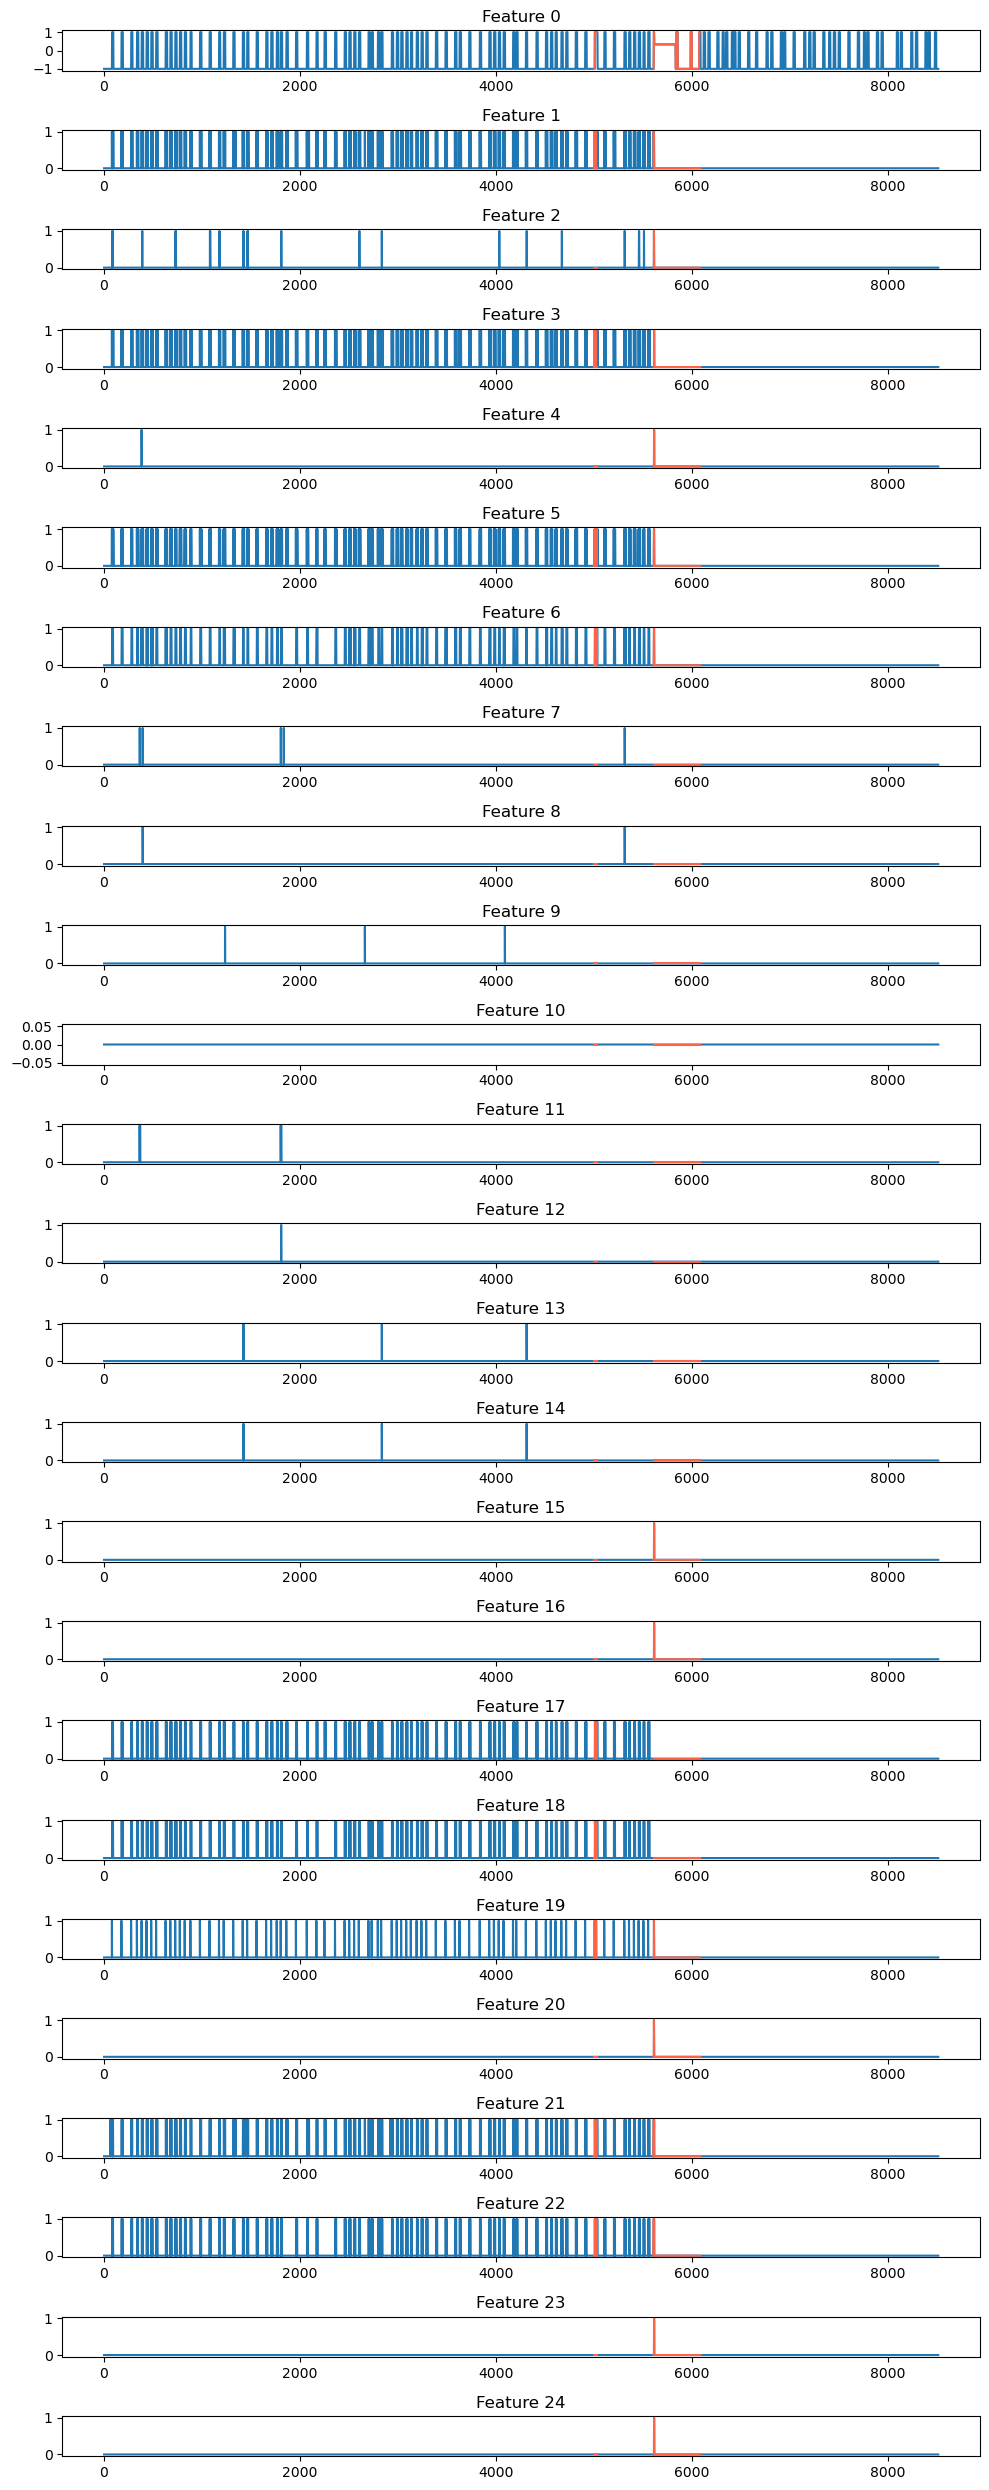

In [8]:
data = np.load('data/test/E-1.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-1']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

In [9]:
ID = 'E_1'

**Topdown**

In [16]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=3,stop=7,df=df)

Max error: 7.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [09:12<00:00, 22.10s/it]

Max_error: 3.000 got 4/25 features detectable 
Max_error: 4.000 got 6/25 features detectable 
Max_error: 5.000 got 6/25 features detectable 
Max_error: 6.000 got 7/25 features detectable 
Max_error: 7.000 got 7/25 features detectable 


In [17]:
save_result(ID,'Topdown',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,E_1,Topdown,3.00,1,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,4
101,E_1,Topdown,4.00,1,0,0,0,0,1,0,...,0,1,1,0,0,1,1,0,0,6
102,E_1,Topdown,5.00,1,0,0,0,0,1,0,...,0,1,1,0,0,1,1,0,0,6
103,E_1,Topdown,6.00,1,0,0,0,0,1,1,...,0,1,1,0,0,1,1,0,0,7


**Slidingwindow**

In [21]:
list_maxerror,list_detect = search_max_error(method='Sldw',start=3,stop=4,df=df)

Max error: 4.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [00:55<00:00,  2.22s/it]

Max_error: 3.000 got 5/25 features detectable 
Max_error: 3.250 got 6/25 features detectable 
Max_error: 3.500 got 3/25 features detectable 
Max_error: 3.750 got 3/25 features detectable 
Max_error: 4.000 got 3/25 features detectable 


In [22]:
save_result(ID,'Slidingwindow',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,E_1,Slidingwindow,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
110,E_1,Slidingwindow,3.00,0,0,0,0,0,1,1,...,0,1,0,0,0,1,1,0,0,5
112,E_1,Slidingwindow,3.50,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
113,E_1,Slidingwindow,3.75,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3


**SWAB**

In [13]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=1,stop=5,df=df)

Max error: 5.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [07:24<00:00, 17.79s/it]

Max_error: 1.000 got 1/25 features detectable 
Max_error: 2.000 got 3/25 features detectable 
Max_error: 3.000 got 1/25 features detectable 
Max_error: 4.000 got 1/25 features detectable 
Max_error: 5.000 got 1/25 features detectable 


In [14]:
save_result(ID,'SWAB',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,E_1,SWAB,2.00,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
119,E_1,SWAB,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
121,E_1,SWAB,3.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
122,E_1,SWAB,4.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**Btu**

In [16]:
list_maxerror,list_detect = search_max_error(method='Btu',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [02:01<00:00,  4.88s/it]

Max_error: 1.000 got 1/25 features detectable 
Max_error: 3.250 got 2/25 features detectable 


In [17]:
save_result(ID,'Bottomup',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,E_1,SWAB,3.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
121,E_1,SWAB,4.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
122,E_1,SWAB,5.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
123,E_1,Bottomup,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## E2

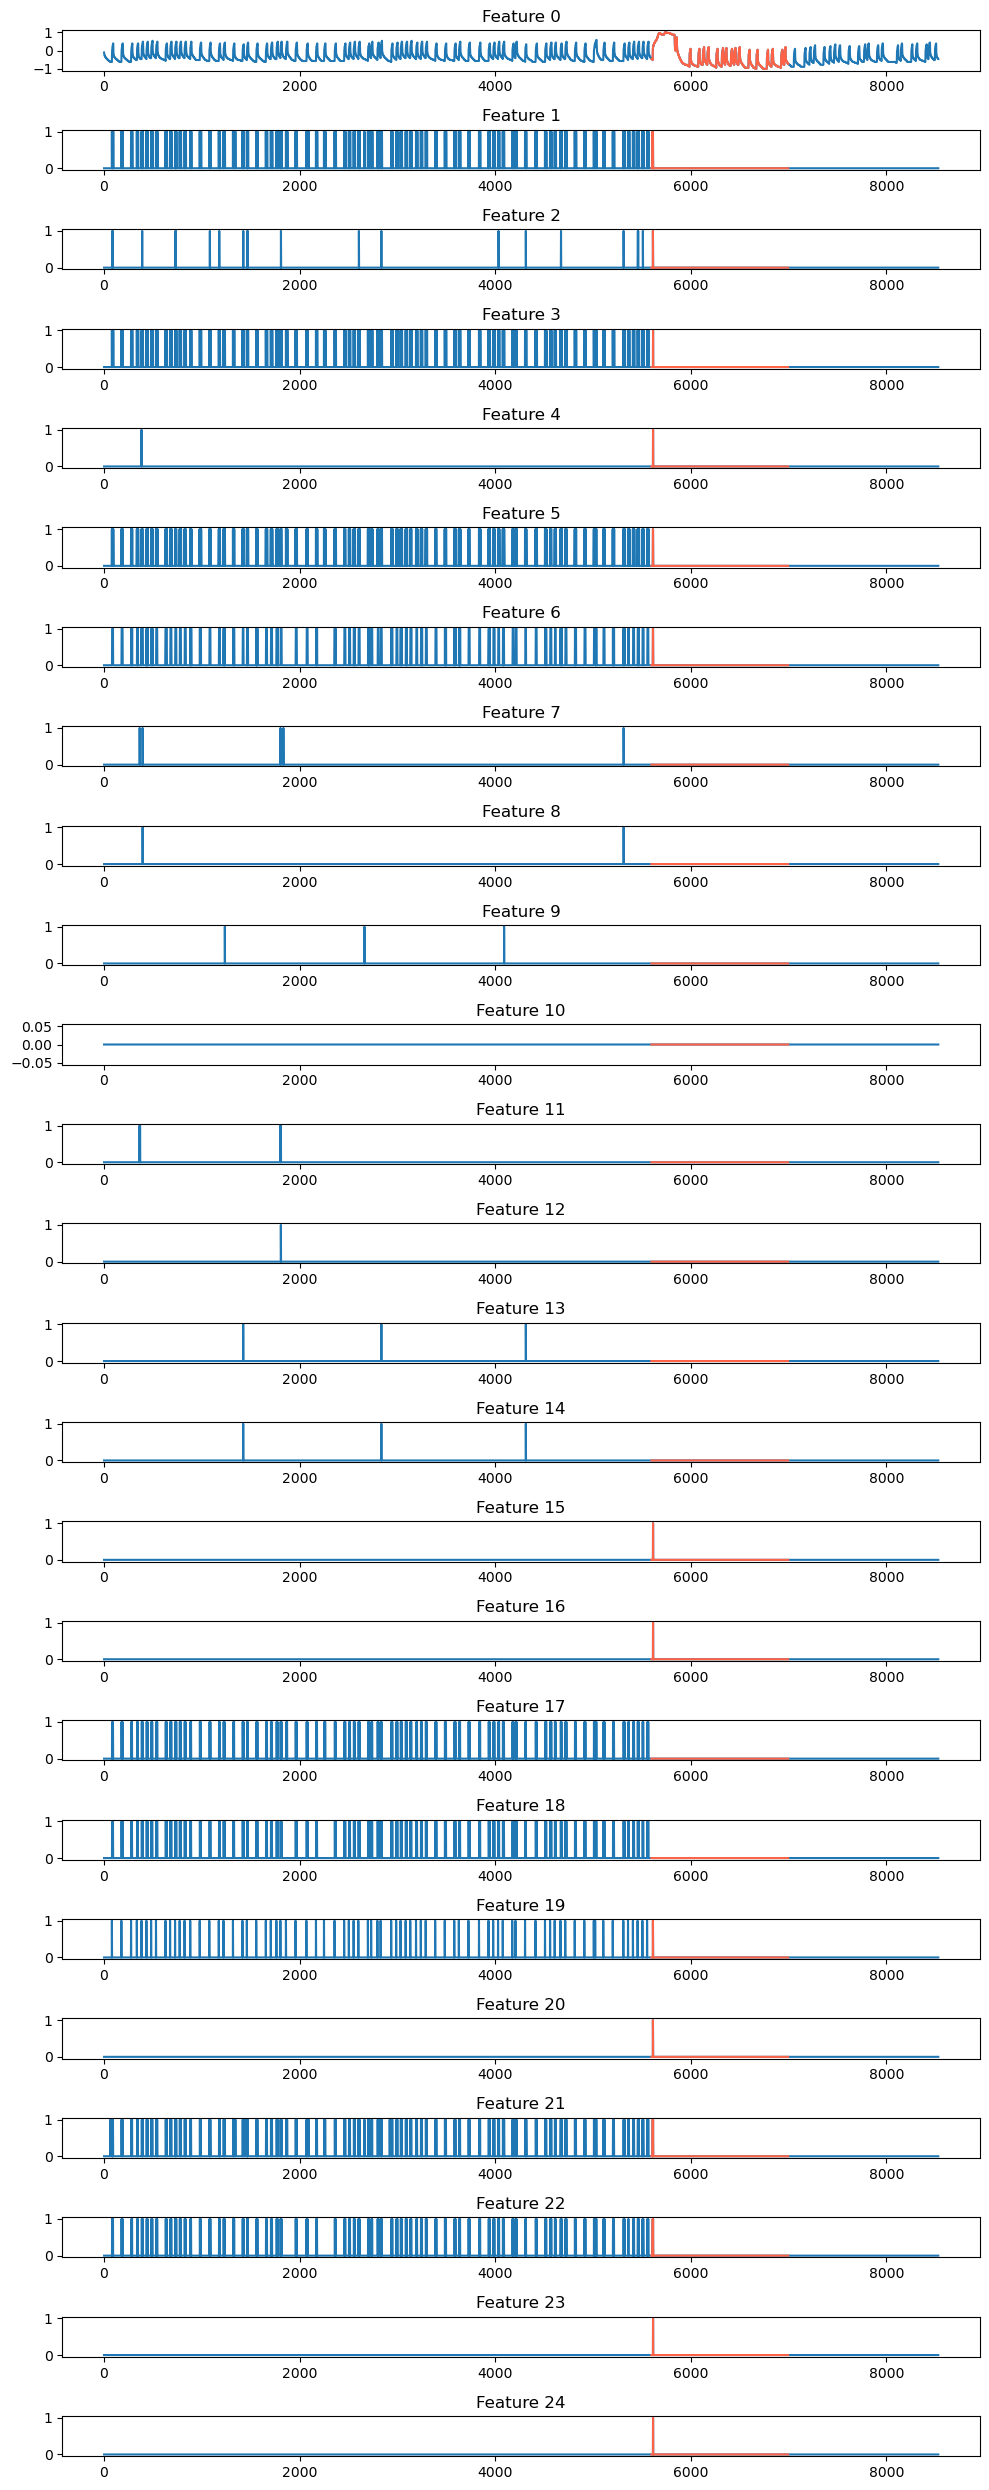

In [18]:
anomaly_index = label_df[label_df['chan_id']=='E-2']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-2.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-2']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_2'

In [21]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=10,stop=100,df=df)

Max error: 100.0000 loop: 100%|████████████████████████████████████████████████████████| 25/25 [06:54<00:00, 16.57s/it]

Cant detect


**Btu**

In [26]:
list_maxerror,list_detect = search_max_error(method='Btu',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:37<00:00,  3.90s/it]

Cant detect


**Sldw**

In [28]:
list_maxerror,list_detect = search_max_error(method='Sldw',start=0.5,stop=4,df=df)

Max error: 4.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [00:58<00:00,  2.32s/it]

Cant detect


In [ ]:
save_result(ID,'Slidingwindow',list_maxerror,list_detect)

**SWAB**

In [24]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [03:15<00:00,  7.83s/it]

Max_error: 1.000 got 22/25 features detectable 
Max_error: 3.250 got 23/25 features detectable 
Max_error: 5.500 got 24/25 features detectable 
Max_error: 7.750 got 23/25 features detectable 
Max_error: 10.000 got 24/25 features detectable 


In [25]:
save_result(ID,'SWAB',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,E_2,SWAB,1.00,0,1,1,1,1,0,1,...,1,1,1,1,1,0,1,1,1,22
126,E_2,SWAB,3.25,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,23
127,E_2,SWAB,5.50,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,24
128,E_2,SWAB,7.75,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,23


In [84]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='E_2']

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.000,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.250,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.500,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.750,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.000,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
5,D_1,Bottomup,1.000,0,1,1,1,1,1,1,...,0,1,1,1,0,1,1,1,1,18
6,D_1,Bottomup,3.250,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,12
7,D_1,Bottomup,5.500,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
8,D_1,Bottomup,7.750,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11
9,D_1,Bottomup,10.000,1,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11


## E_3

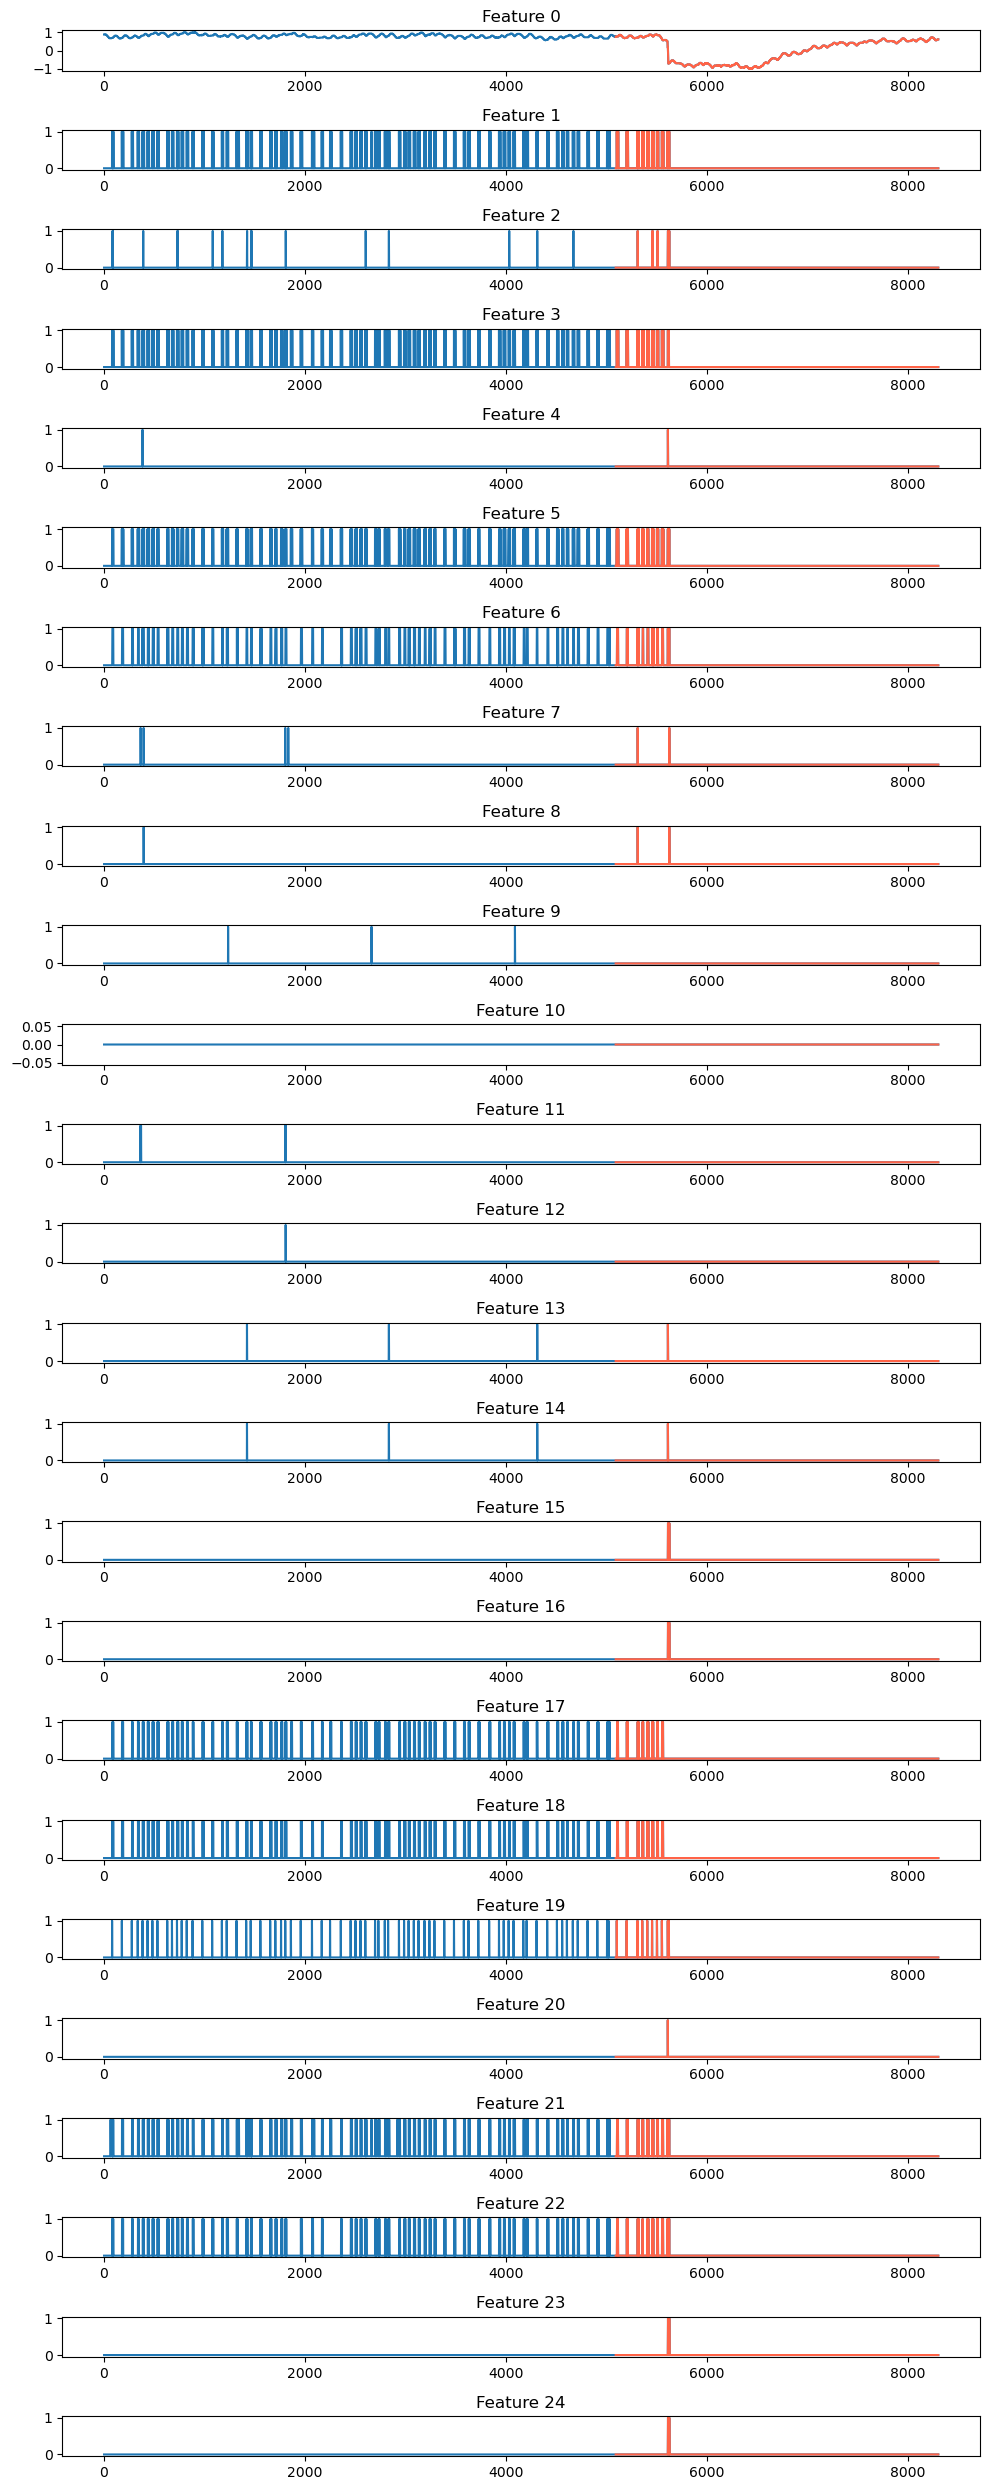

In [7]:
anomaly_index = label_df[label_df['chan_id']=='E-3']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-3.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-3']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_3'

In [8]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|██████████████████████████████████████████████████████| 25/25 [1:37:29<00:00, 233.99s/it]

Max_error: 1.000 got 20/25 features detectable 
Max_error: 3.250 got 17/25 features detectable 
Max_error: 5.500 got 17/25 features detectable 
Max_error: 7.750 got 17/25 features detectable 
Max_error: 10.000 got 17/25 features detectable 


In [9]:
save_result(ID,'Topdown',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,E_3,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,20
131,E_3,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
132,E_3,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
133,E_3,Topdown,7.75,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17


In [14]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=0.1,stop=1.5,df=df)

Max error: 1.5000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [09:26<00:00, 22.67s/it]

Max_error: 0.450 got 3/25 features detectable 
Max_error: 0.800 got 7/25 features detectable 
Max_error: 1.150 got 5/25 features detectable 
Max_error: 1.500 got 5/25 features detectable 


In [15]:
save_result(ID,'SWAB',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,E_3,Slidingwindow,10.00,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
145,E_3,SWAB,0.45,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,3
146,E_3,SWAB,0.80,0,0,1,0,0,1,1,...,0,0,0,1,0,1,1,0,0,7
147,E_3,SWAB,1.15,0,0,1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,5


In [12]:
list_maxerror,list_detect = search_max_error(method='Sldw',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [00:52<00:00,  2.09s/it]

Max_error: 1.000 got 20/25 features detectable 
Max_error: 3.250 got 12/25 features detectable 
Max_error: 5.500 got 11/25 features detectable 
Max_error: 7.750 got 10/25 features detectable 
Max_error: 10.000 got 10/25 features detectable 


In [13]:
save_result(ID,'Slidingwindow',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,E_3,Slidingwindow,1.00,0,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,20
141,E_3,Slidingwindow,3.25,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,12
142,E_3,Slidingwindow,5.50,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11
143,E_3,Slidingwindow,7.75,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10


In [16]:
list_maxerror,list_detect = search_max_error(method='Btu',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:27<00:00,  3.50s/it]

Max_error: 1.000 got 20/25 features detectable 
Max_error: 3.250 got 13/25 features detectable 
Max_error: 5.500 got 10/25 features detectable 
Max_error: 7.750 got 10/25 features detectable 
Max_error: 10.000 got 10/25 features detectable 


In [17]:
save_result(ID,'Bottomup',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,E_3,Bottomup,1.00,0,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,20
150,E_3,Bottomup,3.25,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,13
151,E_3,Bottomup,5.50,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
152,E_3,Bottomup,7.75,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10


## E_4

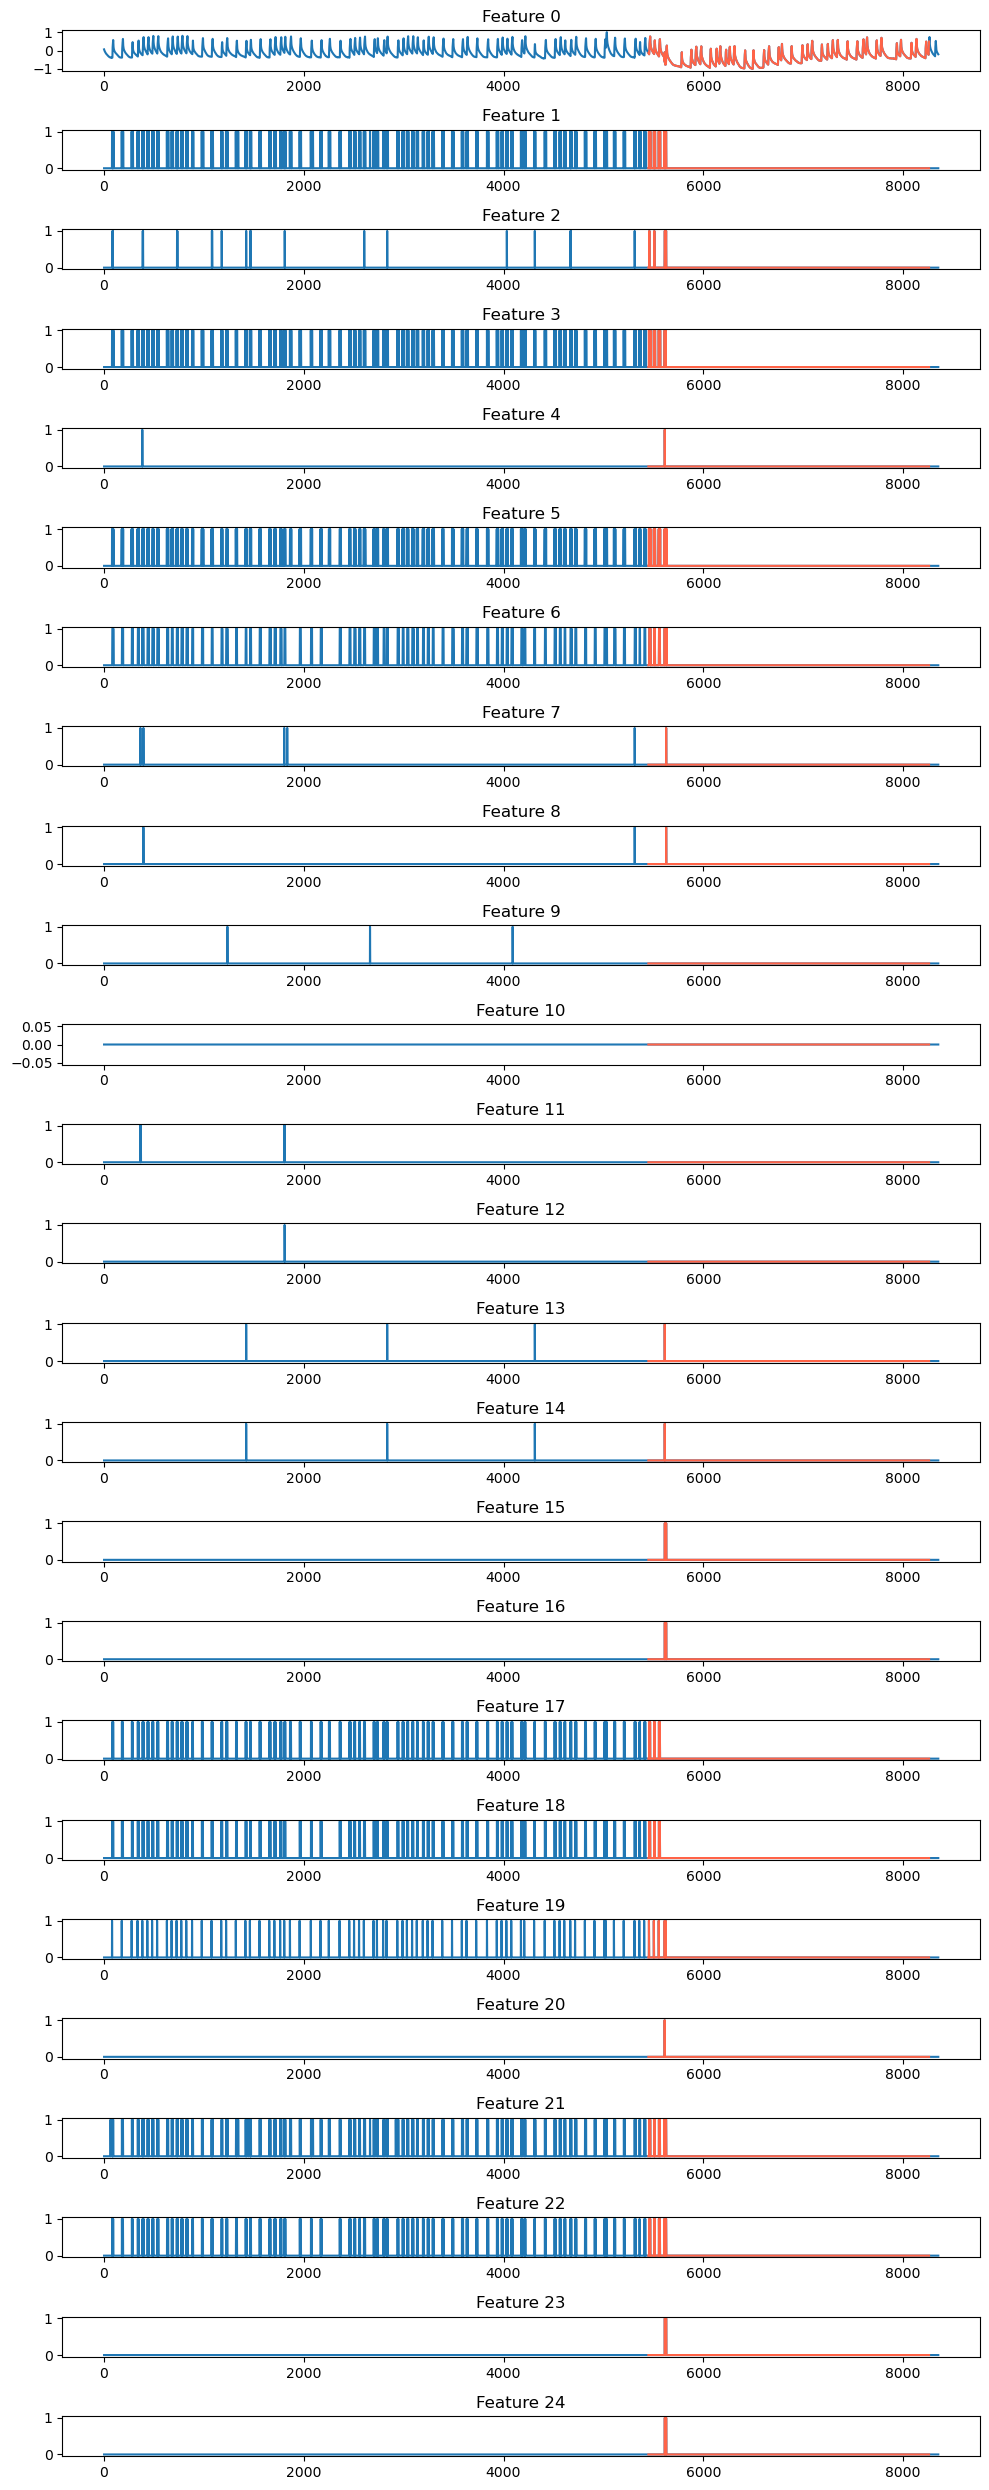

In [19]:
anomaly_index = label_df[label_df['chan_id']=='E-4']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-4.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-4']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_4'

In [20]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [08:44<00:00, 20.97s/it]

Max_error: 1.000 got 19/25 features detectable 
Max_error: 3.250 got 15/25 features detectable 
Max_error: 5.500 got 15/25 features detectable 
Max_error: 7.750 got 15/25 features detectable 
Max_error: 10.000 got 15/25 features detectable 


In [22]:
save_result(ID,'Topdown',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,E_4,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,19
155,E_4,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,15
156,E_4,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,15
157,E_4,Topdown,7.75,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,15


In [27]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=11,stop=15,df=df)

Max error: 15.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [02:37<00:00,  6.30s/it]

Max_error: 11.000 got 4/25 features detectable 
Max_error: 12.000 got 3/25 features detectable 
Max_error: 13.000 got 3/25 features detectable 
Max_error: 14.000 got 1/25 features detectable 
Max_error: 15.000 got 3/25 features detectable 


In [24]:
save_result(ID,'SWAB',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,E_4,SWAB,1.00,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,4
160,E_4,SWAB,3.25,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,2
161,E_4,SWAB,5.50,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,5
162,E_4,SWAB,7.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [25]:
list_maxerror,list_detect = search_max_error(method='Btu',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:36<00:00,  3.87s/it]

Max_error: 1.000 got 19/25 features detectable 
Max_error: 3.250 got 13/25 features detectable 
Max_error: 5.500 got 10/25 features detectable 
Max_error: 7.750 got 10/25 features detectable 
Max_error: 10.000 got 10/25 features detectable 


In [26]:
save_result(ID,'Bottomup',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,E_4,Bottomup,1.00,0,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,19
165,E_4,Bottomup,3.25,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,13
166,E_4,Bottomup,5.50,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
167,E_4,Bottomup,7.75,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10


In [28]:
list_maxerror,list_detect = search_max_error(method='Sldw',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [00:57<00:00,  2.31s/it]

Max_error: 1.000 got 20/25 features detectable 
Max_error: 3.250 got 12/25 features detectable 
Max_error: 5.500 got 11/25 features detectable 
Max_error: 7.750 got 10/25 features detectable 
Max_error: 10.000 got 10/25 features detectable 


In [29]:
save_result(ID,'Slidingwindow',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,E_4,Slidingwindow,1.00,0,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,20
170,E_4,Slidingwindow,3.25,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,12
171,E_4,Slidingwindow,5.50,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11
172,E_4,Slidingwindow,7.75,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10


In [ ]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='E_4']

## E_5

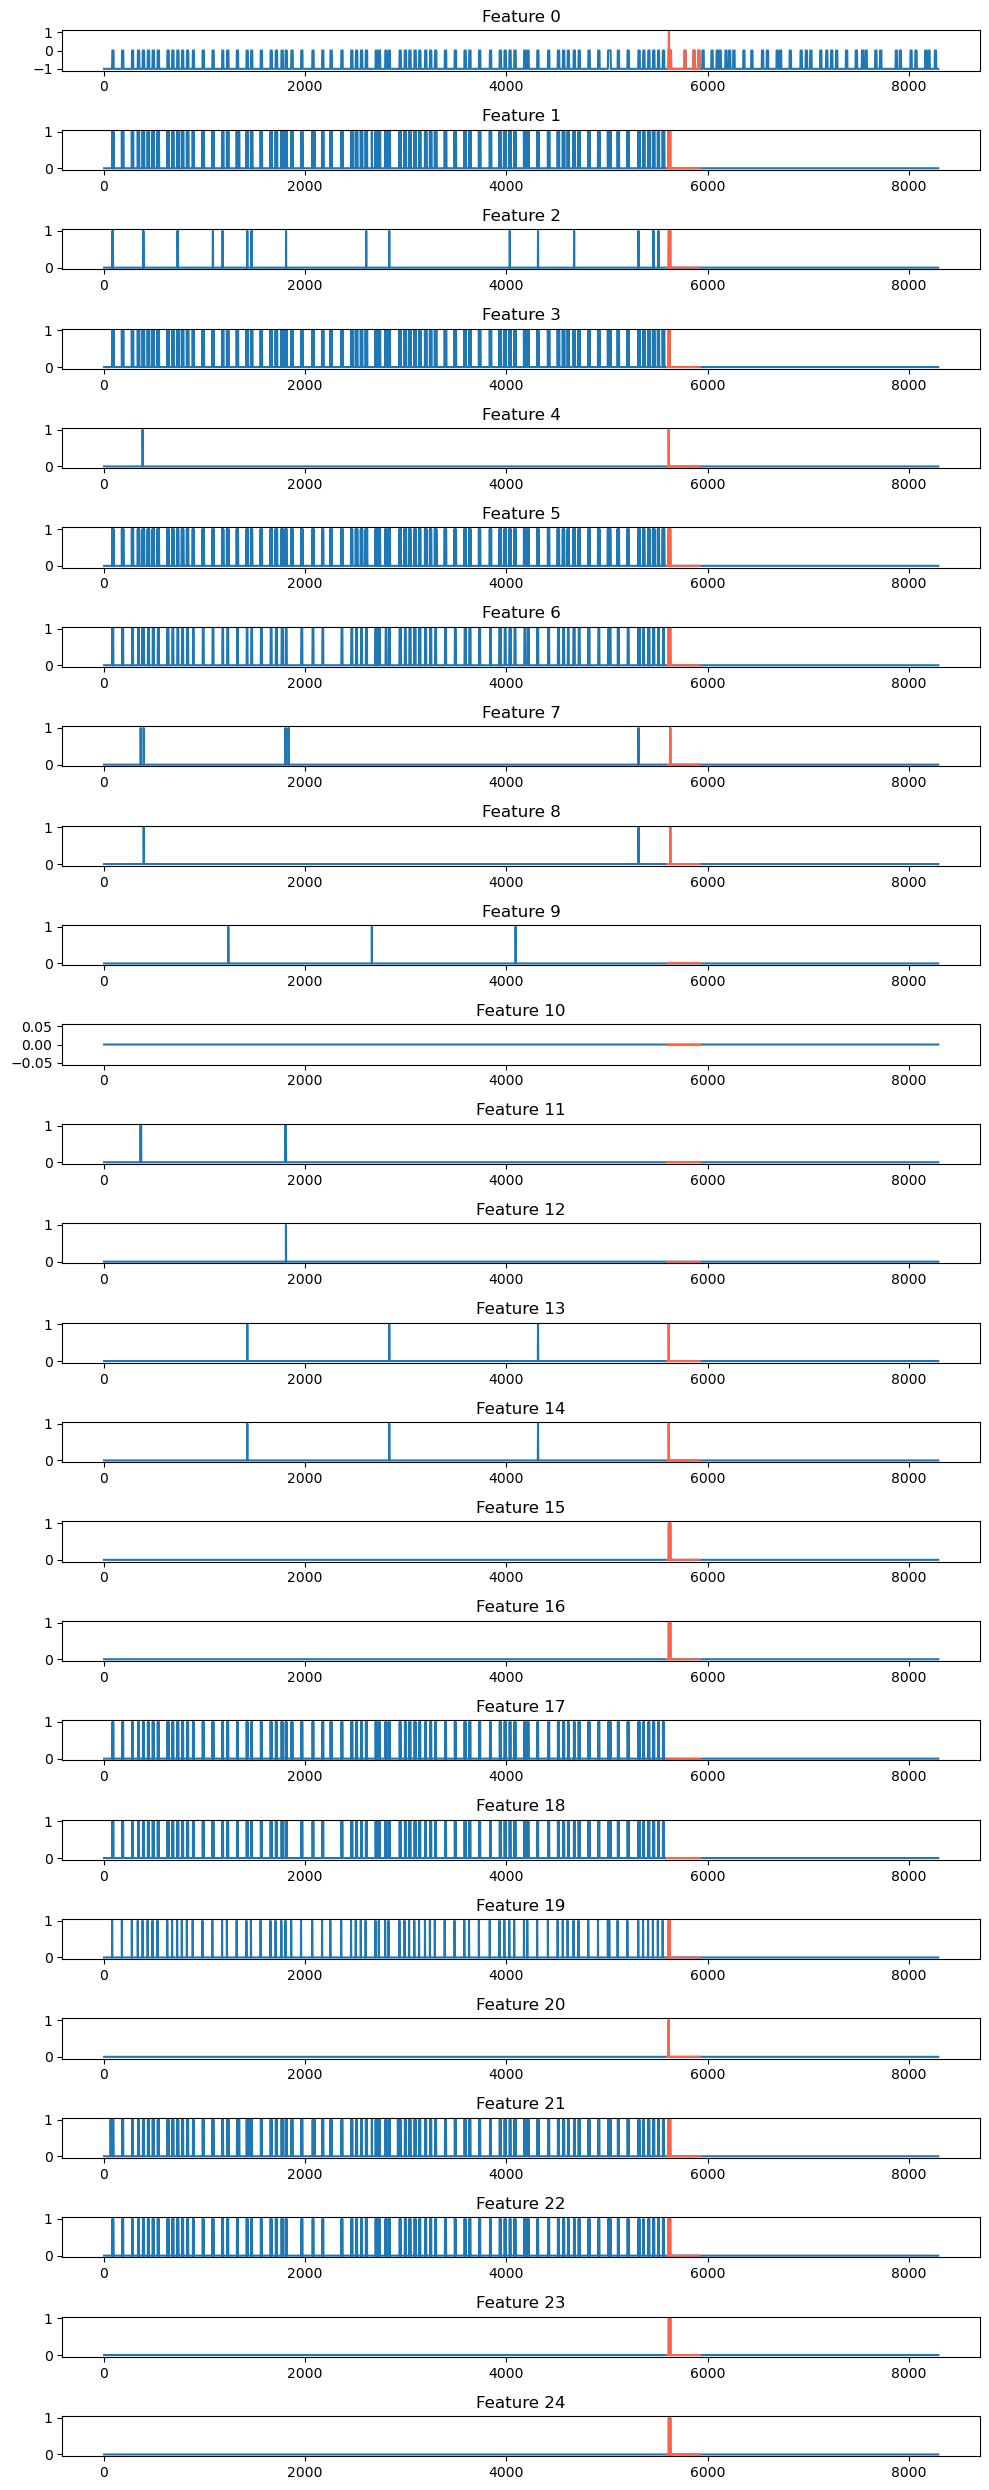

In [7]:
anomaly_index = label_df[label_df['chan_id']=='E-5']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-5.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-5']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_5'

In [31]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [11:44<00:00, 28.17s/it]

Cant detect


In [32]:
save_result(ID,'Topdown',list_maxerror,list_detect)

ValueError: If using all scalar values, you must pass an index

In [33]:
list_maxerror,list_detect = search_max_error(method='Btu',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:36<00:00,  3.87s/it]

Max_error: 10.000 got 1/25 features detectable 


In [34]:
save_result(ID,'Bottomup',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,E_4,Slidingwindow,3.25,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,12
171,E_4,Slidingwindow,5.50,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,11
172,E_4,Slidingwindow,7.75,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
173,E_4,Slidingwindow,10.00,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10


In [35]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [03:32<00:00,  8.50s/it]

Max_error: 7.750 got 1/25 features detectable 
Max_error: 10.000 got 1/25 features detectable 


In [36]:
save_result(ID,'SWAB',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,E_4,Slidingwindow,7.75,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
173,E_4,Slidingwindow,10.00,0,1,1,1,0,1,1,...,0,1,1,1,0,1,1,0,0,10
174,E_5,Bottomup,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
175,E_5,SWAB,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
list_maxerror,list_detect = search_max_error(method='Sldw',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:38<00:00,  3.94s/it]

Cant detect


In [38]:
save_result(ID,'Slidingwindow',list_maxerror,list_detect)

ValueError: If using all scalar values, you must pass an index

In [8]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='E_5']

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
174,E_5,Bottomup,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
175,E_5,SWAB,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
176,E_5,SWAB,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## E_6

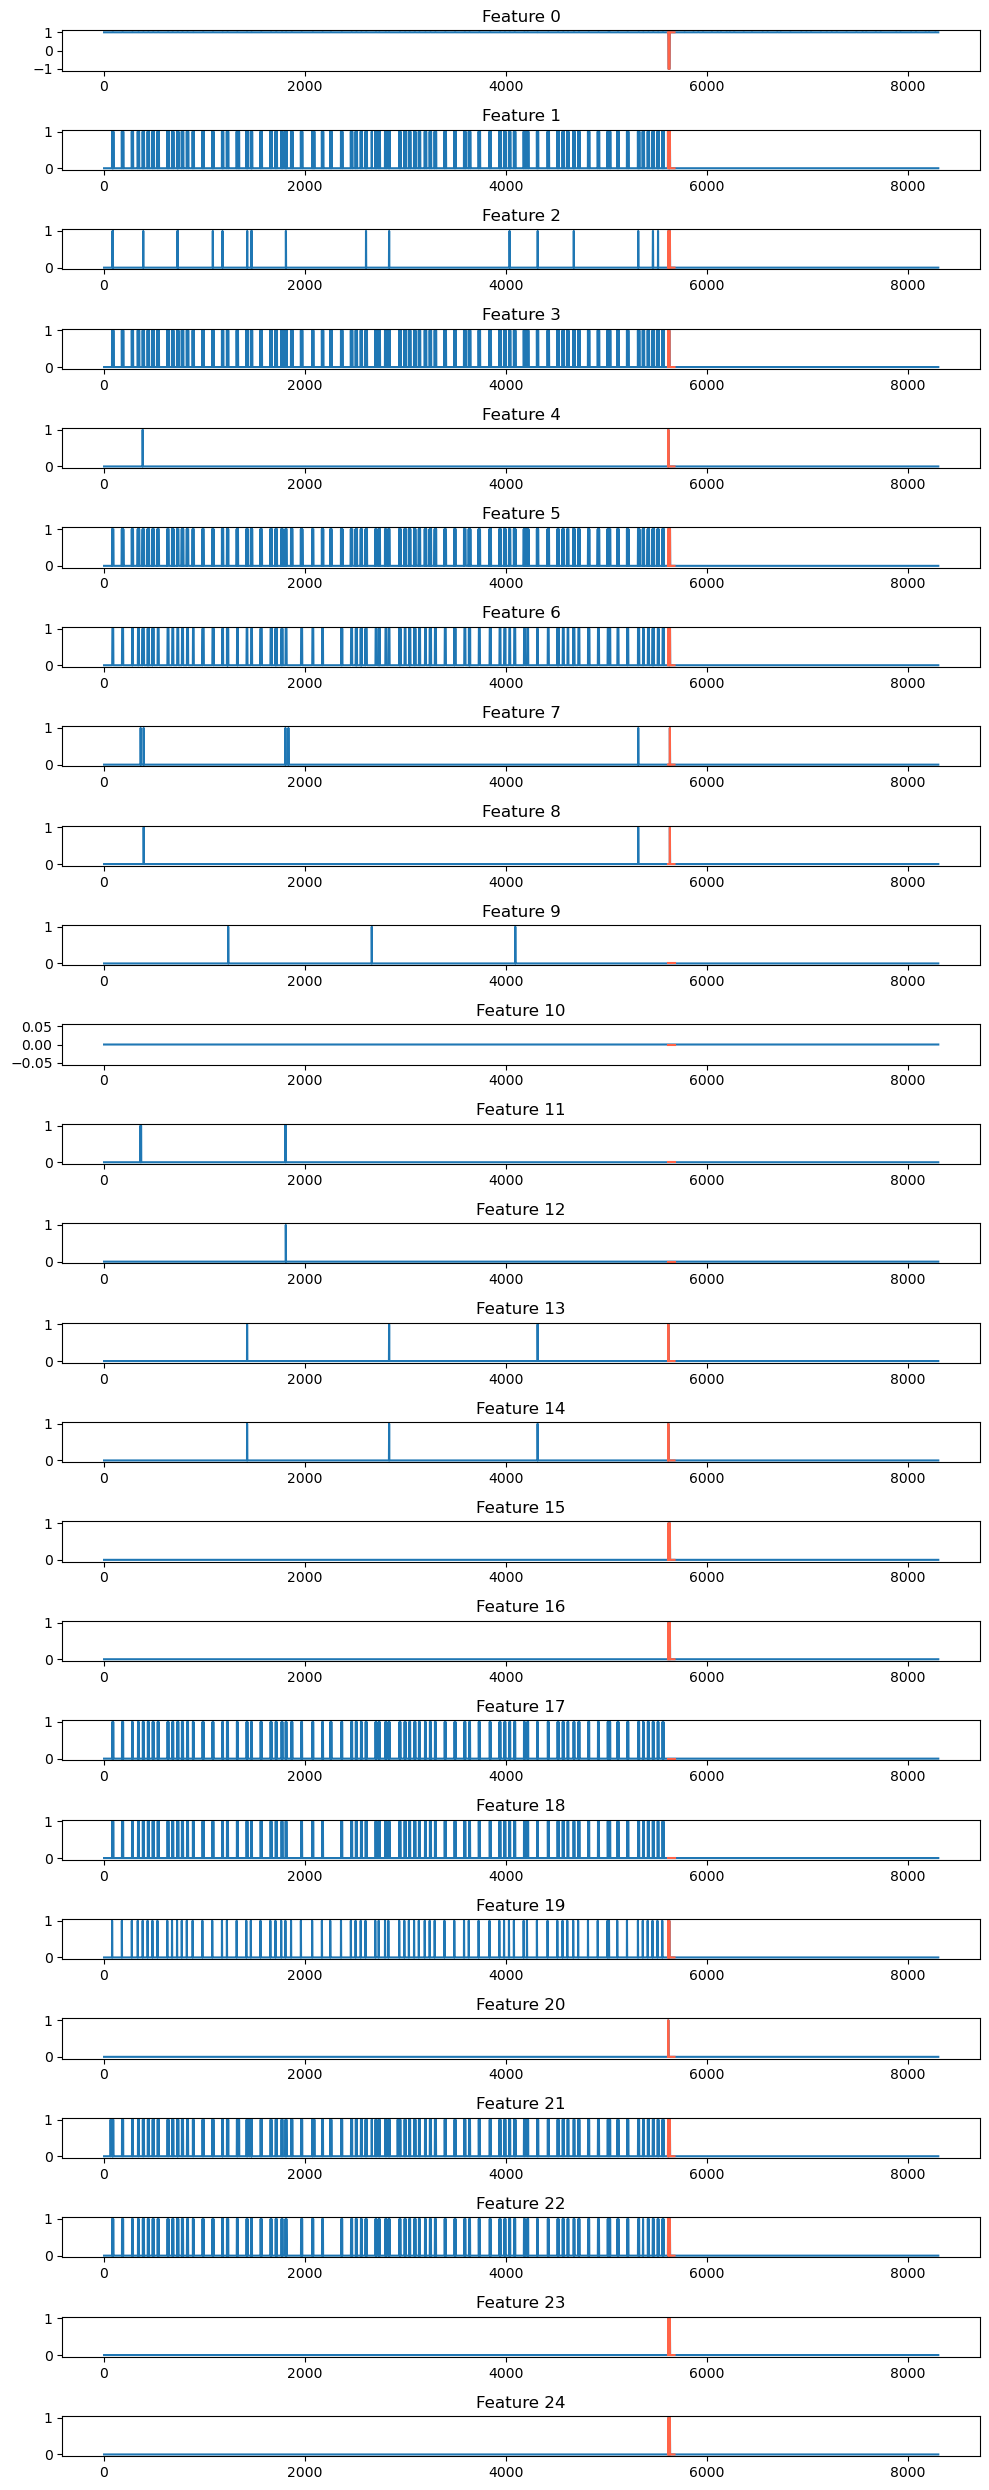

In [10]:
anomaly_index = label_df[label_df['chan_id']=='E-6']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-6.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-6']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_6'

In [11]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [10:05<00:00, 24.21s/it]

Cant detect


In [12]:
save_result(ID,'Topdown',list_maxerror,list_detect)

ValueError: If using all scalar values, you must pass an index

In [13]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [03:22<00:00,  8.12s/it]

Cant detect


In [14]:
save_result(ID,'SWAB',list_maxerror,list_detect)

ValueError: If using all scalar values, you must pass an index

In [15]:
list_maxerror,list_detect = search_max_error(method='Sldw',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [00:56<00:00,  2.27s/it]

Max_error: 3.250 got 5/25 features detectable 
Max_error: 5.500 got 1/25 features detectable 
Max_error: 7.750 got 1/25 features detectable 


In [16]:
save_result(ID,'Slidingwindow',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,E_5,SWAB,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
176,E_5,SWAB,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
177,E_6,Slidingwindow,3.25,0,1,0,0,0,1,1,...,0,0,0,0,0,1,1,0,0,5
178,E_6,Slidingwindow,5.50,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
list_maxerror,list_detect = search_max_error(method='Btu',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:51<00:00,  4.45s/it]

Cant detect


In [18]:
save_result(ID,'Bottomup',list_maxerror,list_detect)

ValueError: If using all scalar values, you must pass an index

## E_7(Cant detect)

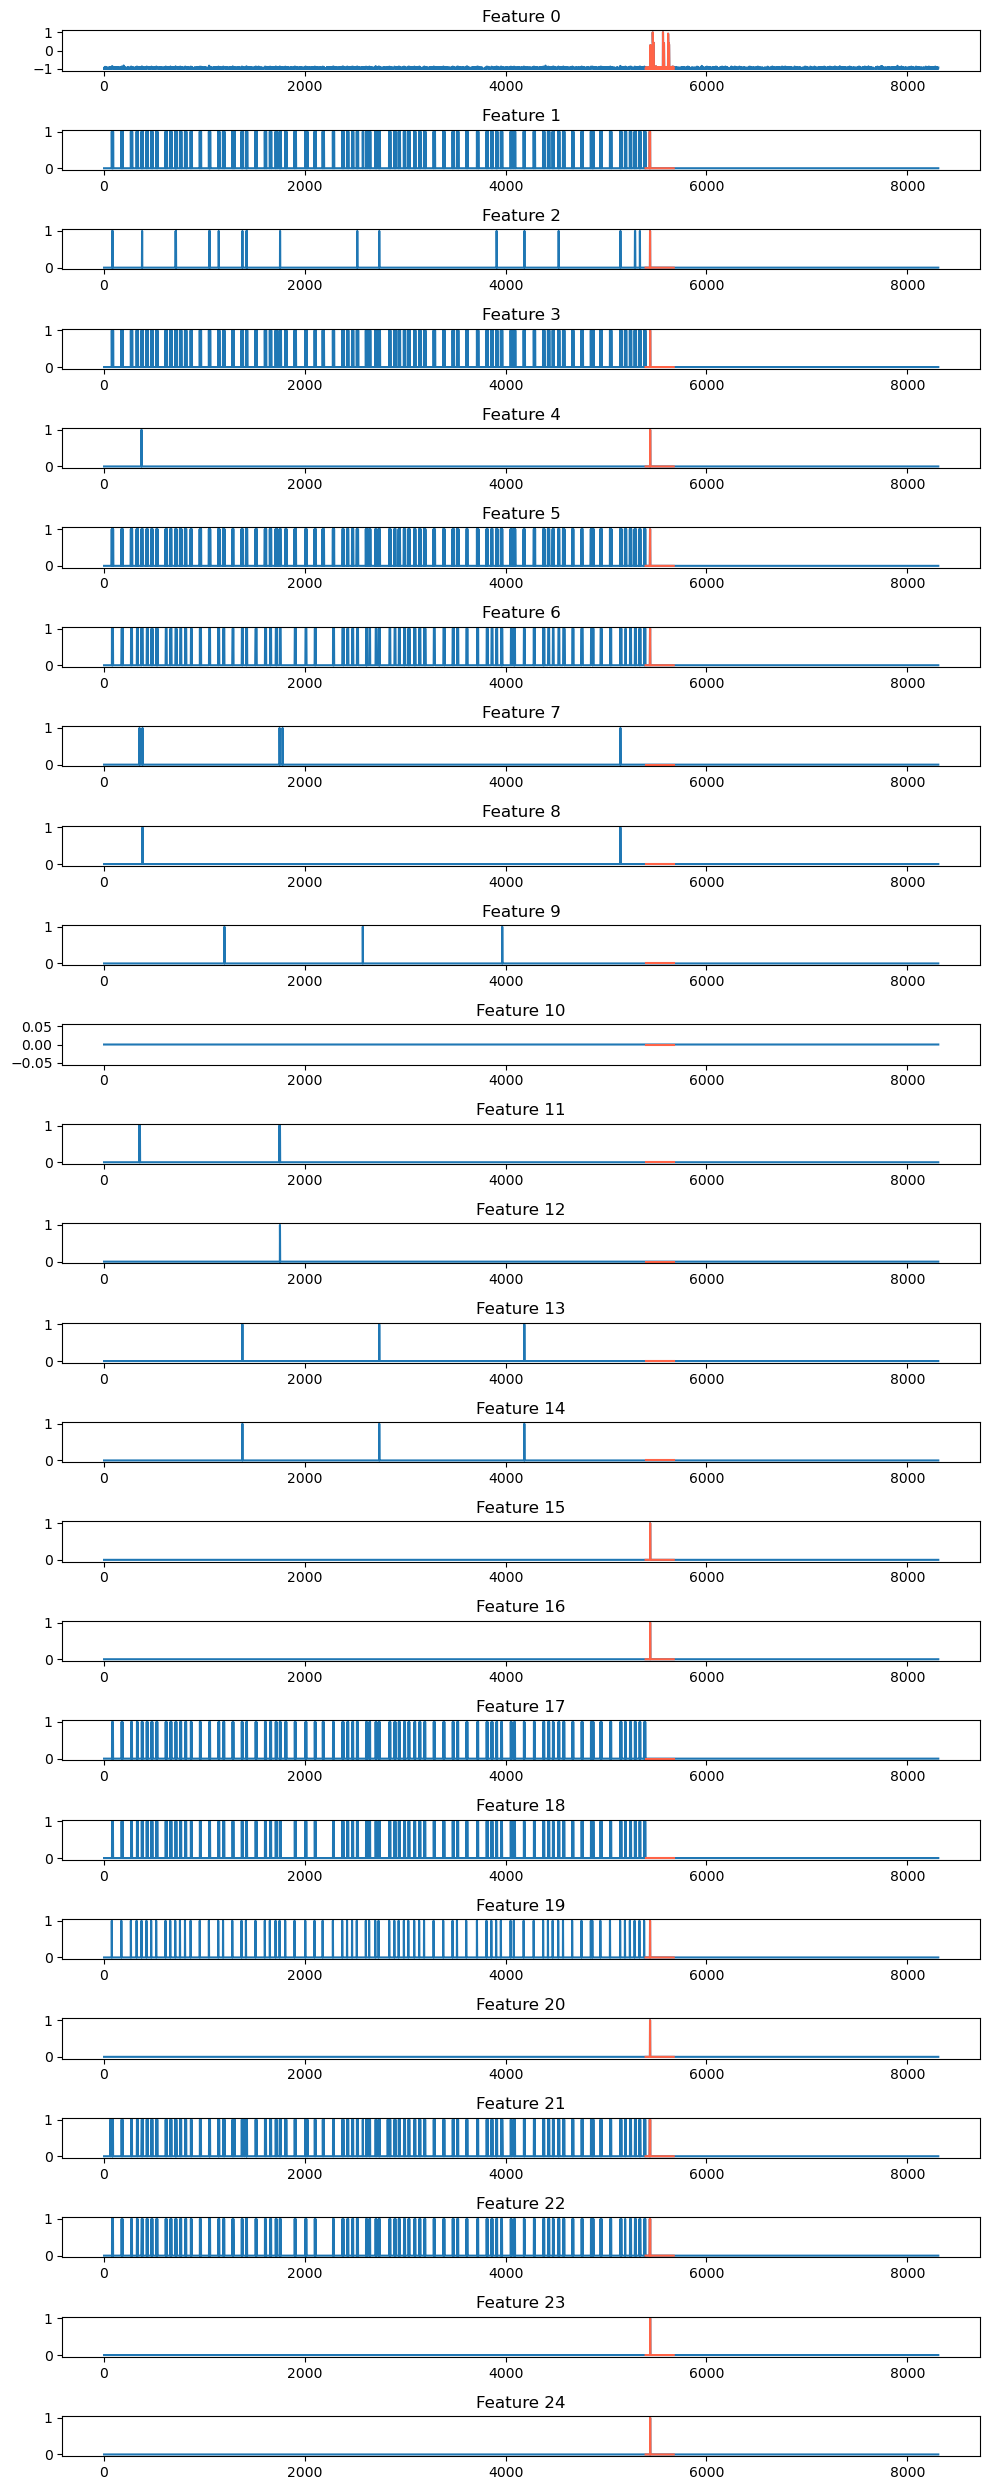

In [8]:
anomaly_index = label_df[label_df['chan_id']=='E-7']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-7.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-7']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_7'

In [25]:
list_maxerror,list_detect = search_max_error(method='Topdown',start=0.1,stop=1,df=df)

Max error: 1.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [10:57<00:00, 26.30s/it]

Cant detect


In [26]:
save_result(ID,'Topdown',list_maxerror,list_detect)

ValueError: If using all scalar values, you must pass an index

In [8]:
list_maxerror,list_detect = search_max_error(method='Btu',start=0.1,stop=1,df=df)

Max error: 1.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [02:32<00:00,  6.11s/it]

Cant detect


In [9]:
save_result(ID,'Bottomup',list_maxerror,list_detect)

ValueError: If using all scalar values, you must pass an index

In [10]:
list_maxerror,list_detect = search_max_error(method='Sldw',start=0.1,stop=1,df=df)

Max error: 1.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [01:15<00:00,  3.03s/it]

Cant detect


In [ ]:
save_result(ID,'Slidingwindow',list_maxerror,list_detect)

In [11]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=0.1,stop=1,df=df)

Max error: 1.0000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [13:45<00:00, 33.01s/it]

Cant detect


In [ ]:
save_result(ID,'SWAB',list_maxerror,list_detect)

In [7]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='E_7']

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total


In [10]:
def run_all_and_save(ID,start=1,stop=10):
    method_dict = {'Topdown':'Topdown','Btu':'Bottomup','Sldw':'Slidingwindow','SWAB':'SWAB'}
    for key,val in method_dict.items():
        list_maxerror,list_detect = search_max_error(method=key,start=start,stop=stop,df=df)
        try:
            save_result(ID,val,list_maxerror,list_detect)
        except:
            print(f'Cant save  NoneType at {val}')

In [ ]:
run_all_and_save(ID,start=0.01,stop=0.1)

Max error: 0.1000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [16:54<00:00, 40.60s/it]


Cant detect
Cant save  NoneType at Topdown


Max error: 0.1000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [03:00<00:00,  7.20s/it]


Cant detect
Cant save  NoneType at Bottomup


Max error: 0.1000 loop: 100%|██████████████████████████████████████████████████████████| 25/25 [01:49<00:00,  4.39s/it]


Cant detect
Cant save  NoneType at Slidingwindow


Max error: 0.0100 loop:  20%|███████████▌                                              | 5/25 [12:52<37:52, 113.62s/it]

## E_8

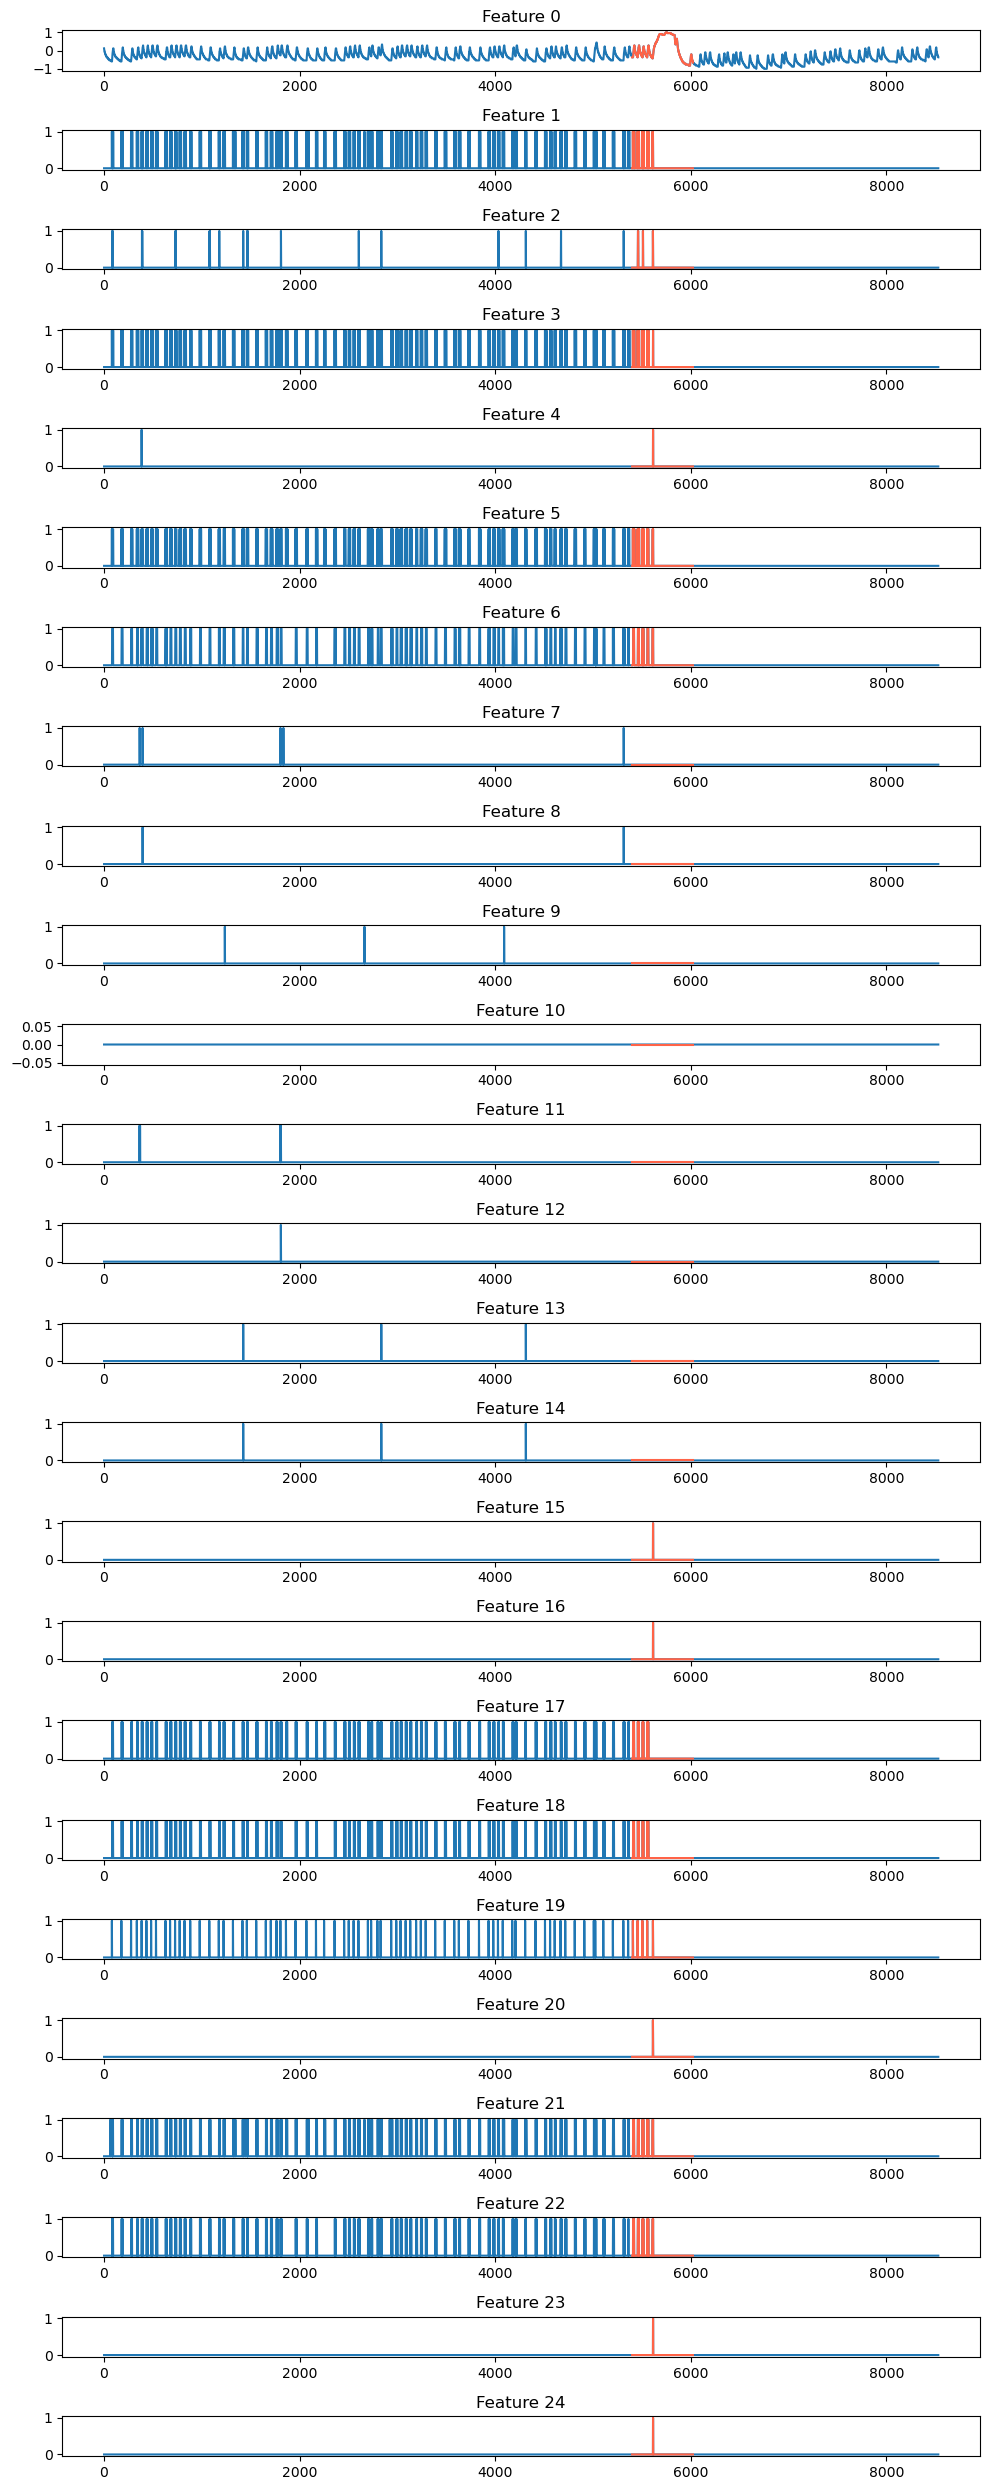

In [10]:
anomaly_index = label_df[label_df['chan_id']=='E-8']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-8.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-8']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_8'

In [11]:
run_all_and_save(ID,start=1,stop=10)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [09:09<00:00, 21.99s/it]


Cant detect
Cant save  NoneType at Topdown


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:35<00:00,  3.83s/it]

Max_error: 5.500 got 1/25 features detectable 
Max_error: 7.750 got 1/25 features detectable 
Max_error: 10.000 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,F_3,Slidingwindow,5.50,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,2
190,F_3,Slidingwindow,7.75,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
191,E_8,Bottomup,5.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
192,E_8,Bottomup,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [00:57<00:00,  2.32s/it]


Cant detect
Cant save  NoneType at Slidingwindow


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [04:48<00:00, 11.54s/it]

Max_error: 1.000 got 16/25 features detectable 
Max_error: 3.250 got 21/25 features detectable 
Max_error: 5.500 got 19/25 features detectable 
Max_error: 7.750 got 23/25 features detectable 
Max_error: 10.000 got 24/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,E_8,SWAB,1.00,0,0,1,0,1,0,0,...,1,1,1,0,1,0,0,1,1,16
195,E_8,SWAB,3.25,0,1,1,1,1,0,0,...,1,1,1,1,1,1,0,1,1,21
196,E_8,SWAB,5.50,0,1,1,1,1,0,0,...,1,0,0,1,1,1,0,1,1,19
197,E_8,SWAB,7.75,1,1,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,23


In [12]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='E_8']

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
191,E_8,Bottomup,5.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
192,E_8,Bottomup,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
193,E_8,Bottomup,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
194,E_8,SWAB,1.00,0,0,1,0,1,0,0,...,1,1,1,0,1,0,0,1,1,16
195,E_8,SWAB,3.25,0,1,1,1,1,0,0,...,1,1,1,1,1,1,0,1,1,21
196,E_8,SWAB,5.50,0,1,1,1,1,0,0,...,1,0,0,1,1,1,0,1,1,19
197,E_8,SWAB,7.75,1,1,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,23
198,E_8,SWAB,10.00,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,24


# E_9

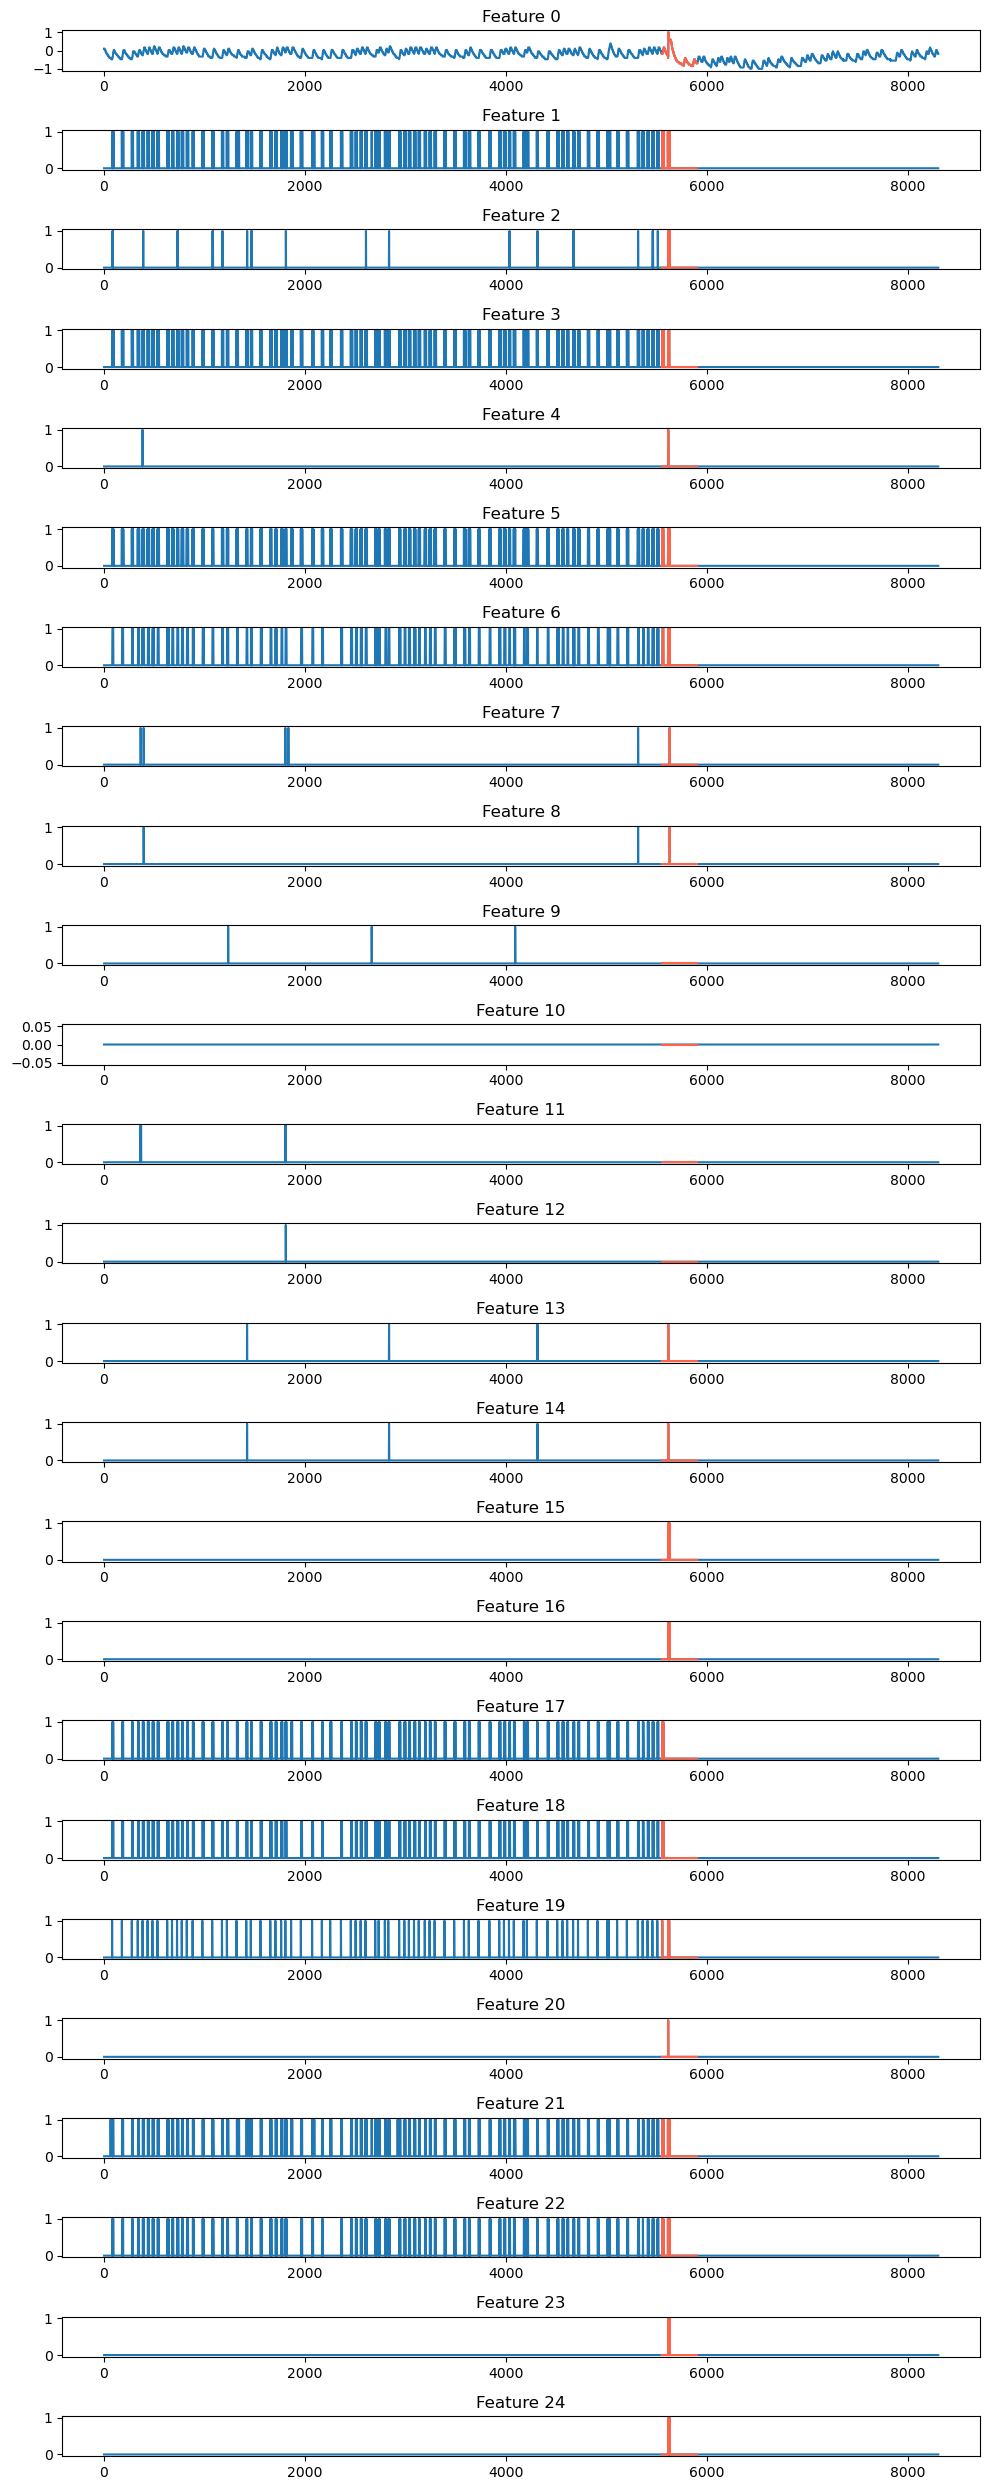

In [13]:
anomaly_index = label_df[label_df['chan_id']=='E-9']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-9.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-9']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_9'

In [14]:
run_all_and_save(ID,start=1,stop=10)

Max error: 10.0000 loop: 100%|██████████████████████████████████████████████████████| 25/25 [1:24:06<00:00, 201.86s/it]

Max_error: 3.250 got 1/25 features detectable 
Max_error: 5.500 got 1/25 features detectable 
Max_error: 7.750 got 1/25 features detectable 
Max_error: 10.000 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,G_1,Slidingwindow,10.00,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,2
214,E_9,Topdown,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
215,E_9,Topdown,5.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
216,E_9,Topdown,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [02:25<00:00,  5.81s/it]

Max_error: 1.000 got 1/25 features detectable 
Max_error: 3.250 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,E_9,Topdown,5.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
216,E_9,Topdown,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
217,E_9,Topdown,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
218,E_9,Bottomup,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [03:55<00:00,  9.42s/it]

Max_error: 5.500 got 2/25 features detectable 
Max_error: 7.750 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,E_9,Topdown,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
218,E_9,Bottomup,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
219,E_9,Bottomup,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
220,E_9,Slidingwindow,5.50,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,2


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [03:37<00:00,  8.70s/it]

Max_error: 3.250 got 1/25 features detectable 
Max_error: 5.500 got 1/25 features detectable 
Max_error: 7.750 got 1/25 features detectable 
Max_error: 10.000 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,G_1,SWAB,10.00,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,2
227,E_9,SWAB,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
228,E_9,SWAB,5.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
229,E_9,SWAB,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='E_9']

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
214,E_9,Topdown,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
215,E_9,Topdown,5.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
216,E_9,Topdown,7.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
217,E_9,Topdown,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
218,E_9,Bottomup,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
219,E_9,Bottomup,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
220,E_9,Slidingwindow,5.50,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,2
221,E_9,Slidingwindow,7.75,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
227,E_9,SWAB,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
228,E_9,SWAB,5.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## E_10

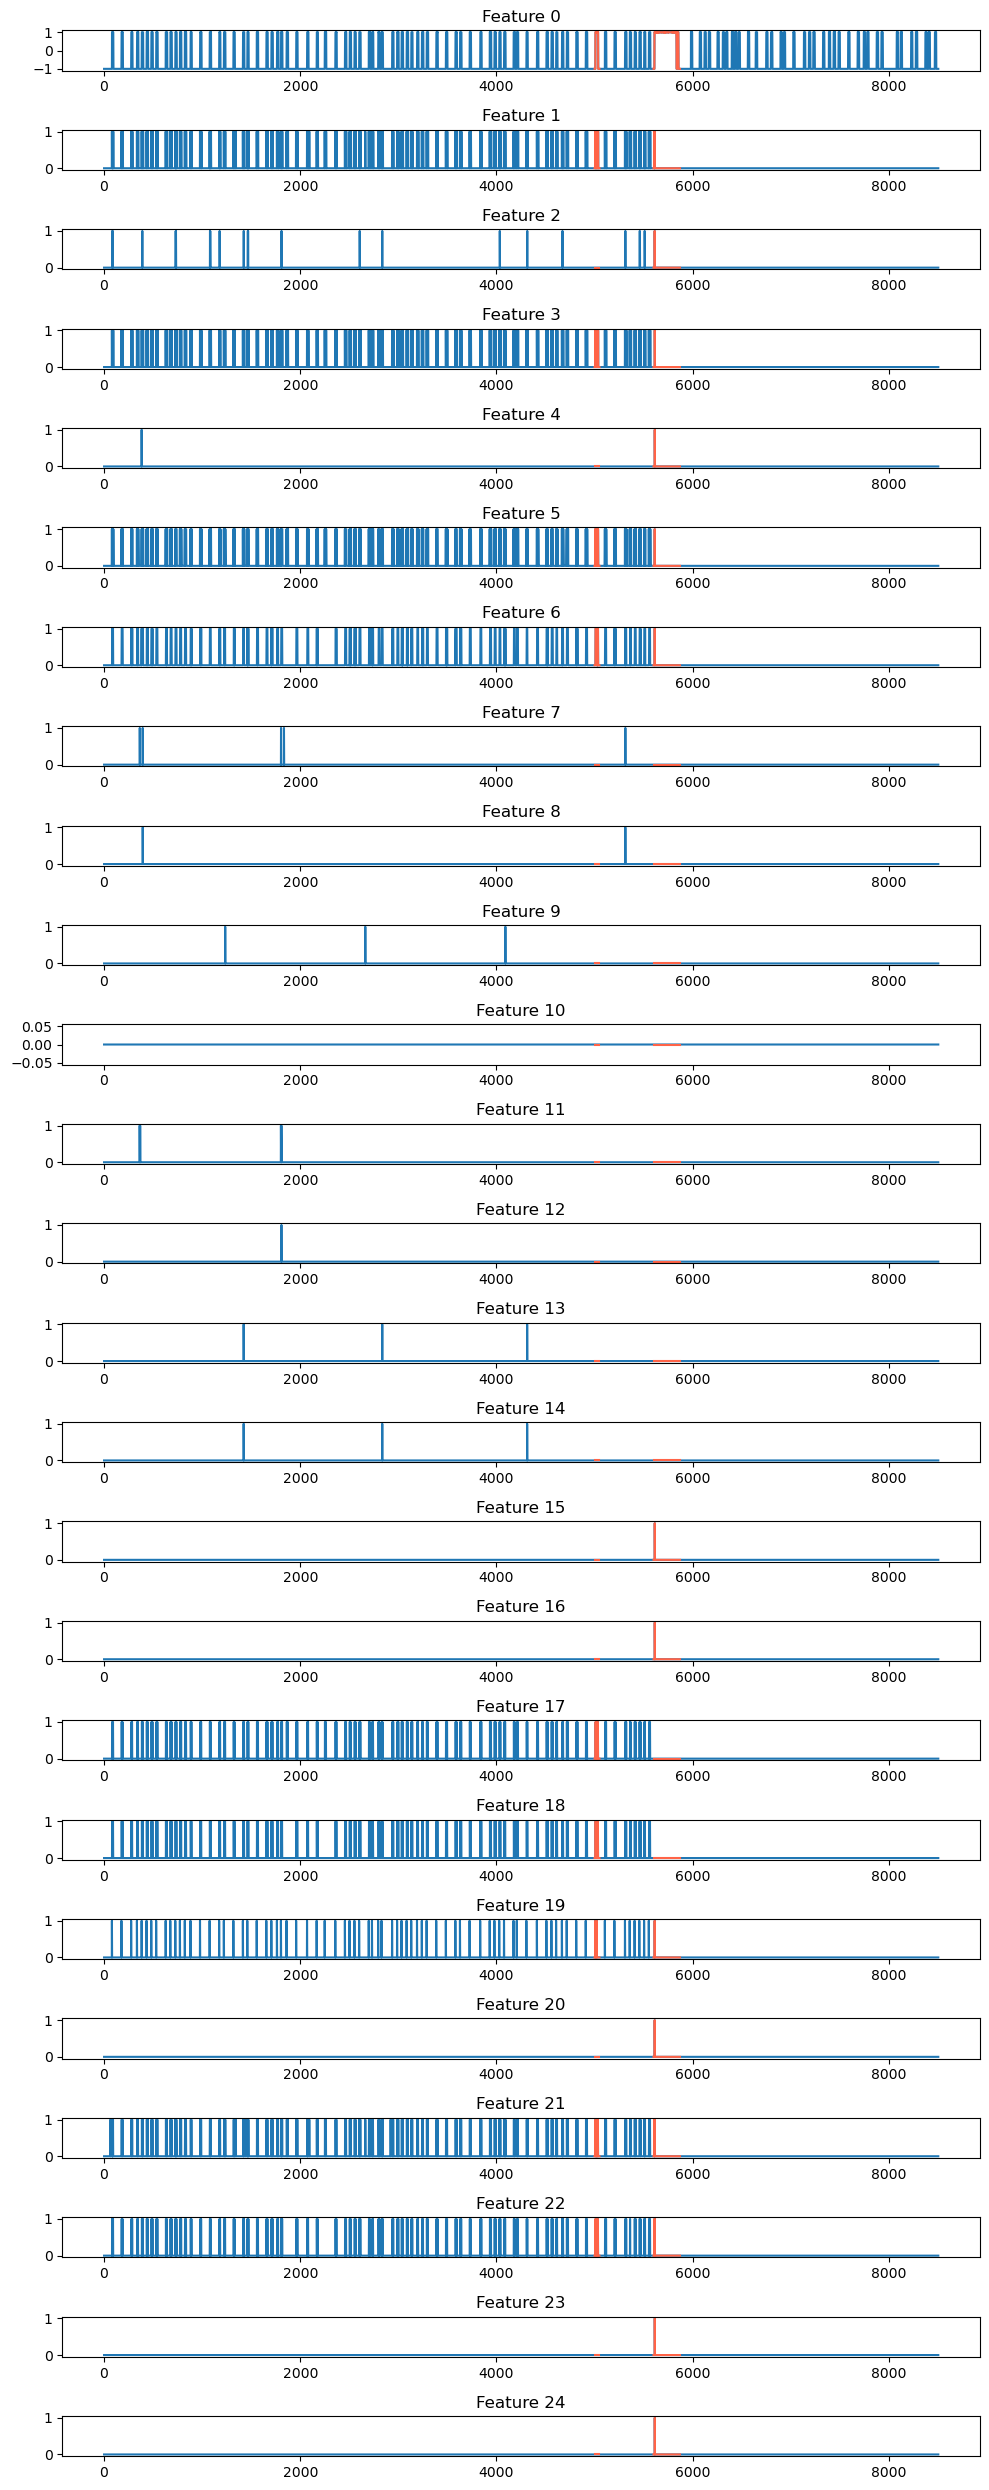

In [14]:
anomaly_index = label_df[label_df['chan_id']=='E-10']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-10.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-10']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_10'

In [ ]:
run_all_and_save(ID,start=1,stop=10)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [13:28<00:00, 32.35s/it]

Max_error: 1.000 got 1/25 features detectable 
Max_error: 3.250 got 1/25 features detectable 
Max_error: 5.500 got 2/25 features detectable 
Max_error: 7.750 got 3/25 features detectable 
Max_error: 10.000 got 3/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,E_10,Topdown,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
247,E_10,Topdown,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
248,E_10,Topdown,5.50,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
249,E_10,Topdown,7.75,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [02:08<00:00,  5.13s/it]

Max_error: 1.000 got 1/25 features detectable 
Max_error: 3.250 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,E_10,Topdown,5.50,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
249,E_10,Topdown,7.75,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
250,E_10,Topdown,10.00,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
251,E_10,Bottomup,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:17<00:00,  3.11s/it]

Max_error: 1.000 got 1/25 features detectable 
Max_error: 5.500 got 3/25 features detectable 
Max_error: 7.750 got 3/25 features detectable 
Max_error: 10.000 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,E_10,Bottomup,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
253,E_10,Slidingwindow,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
254,E_10,Slidingwindow,5.50,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
255,E_10,Slidingwindow,7.75,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3


Max error: 1.0000 loop:  20%|███████████▊                                               | 5/25 [07:20<19:54, 59.71s/it]

In [15]:
list_maxerror,list_detect = search_max_error(method='SWAB',start=1,stop=10,df=df)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [04:58<00:00, 11.93s/it]

Max_error: 1.000 got 1/25 features detectable 
Max_error: 3.250 got 1/25 features detectable 


In [16]:
save_result(ID,'SWAB',list_maxerror,list_detect)

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,E_11,Slidingwindow,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
273,E_11,SWAB,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
274,E_11,SWAB,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
275,E_10,SWAB,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='E_10']

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
246,E_10,Topdown,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
247,E_10,Topdown,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
248,E_10,Topdown,5.50,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
249,E_10,Topdown,7.75,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
250,E_10,Topdown,10.00,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
251,E_10,Bottomup,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
252,E_10,Bottomup,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
253,E_10,Slidingwindow,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
254,E_10,Slidingwindow,5.50,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
255,E_10,Slidingwindow,7.75,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3


## E_11 (2 anomalies)

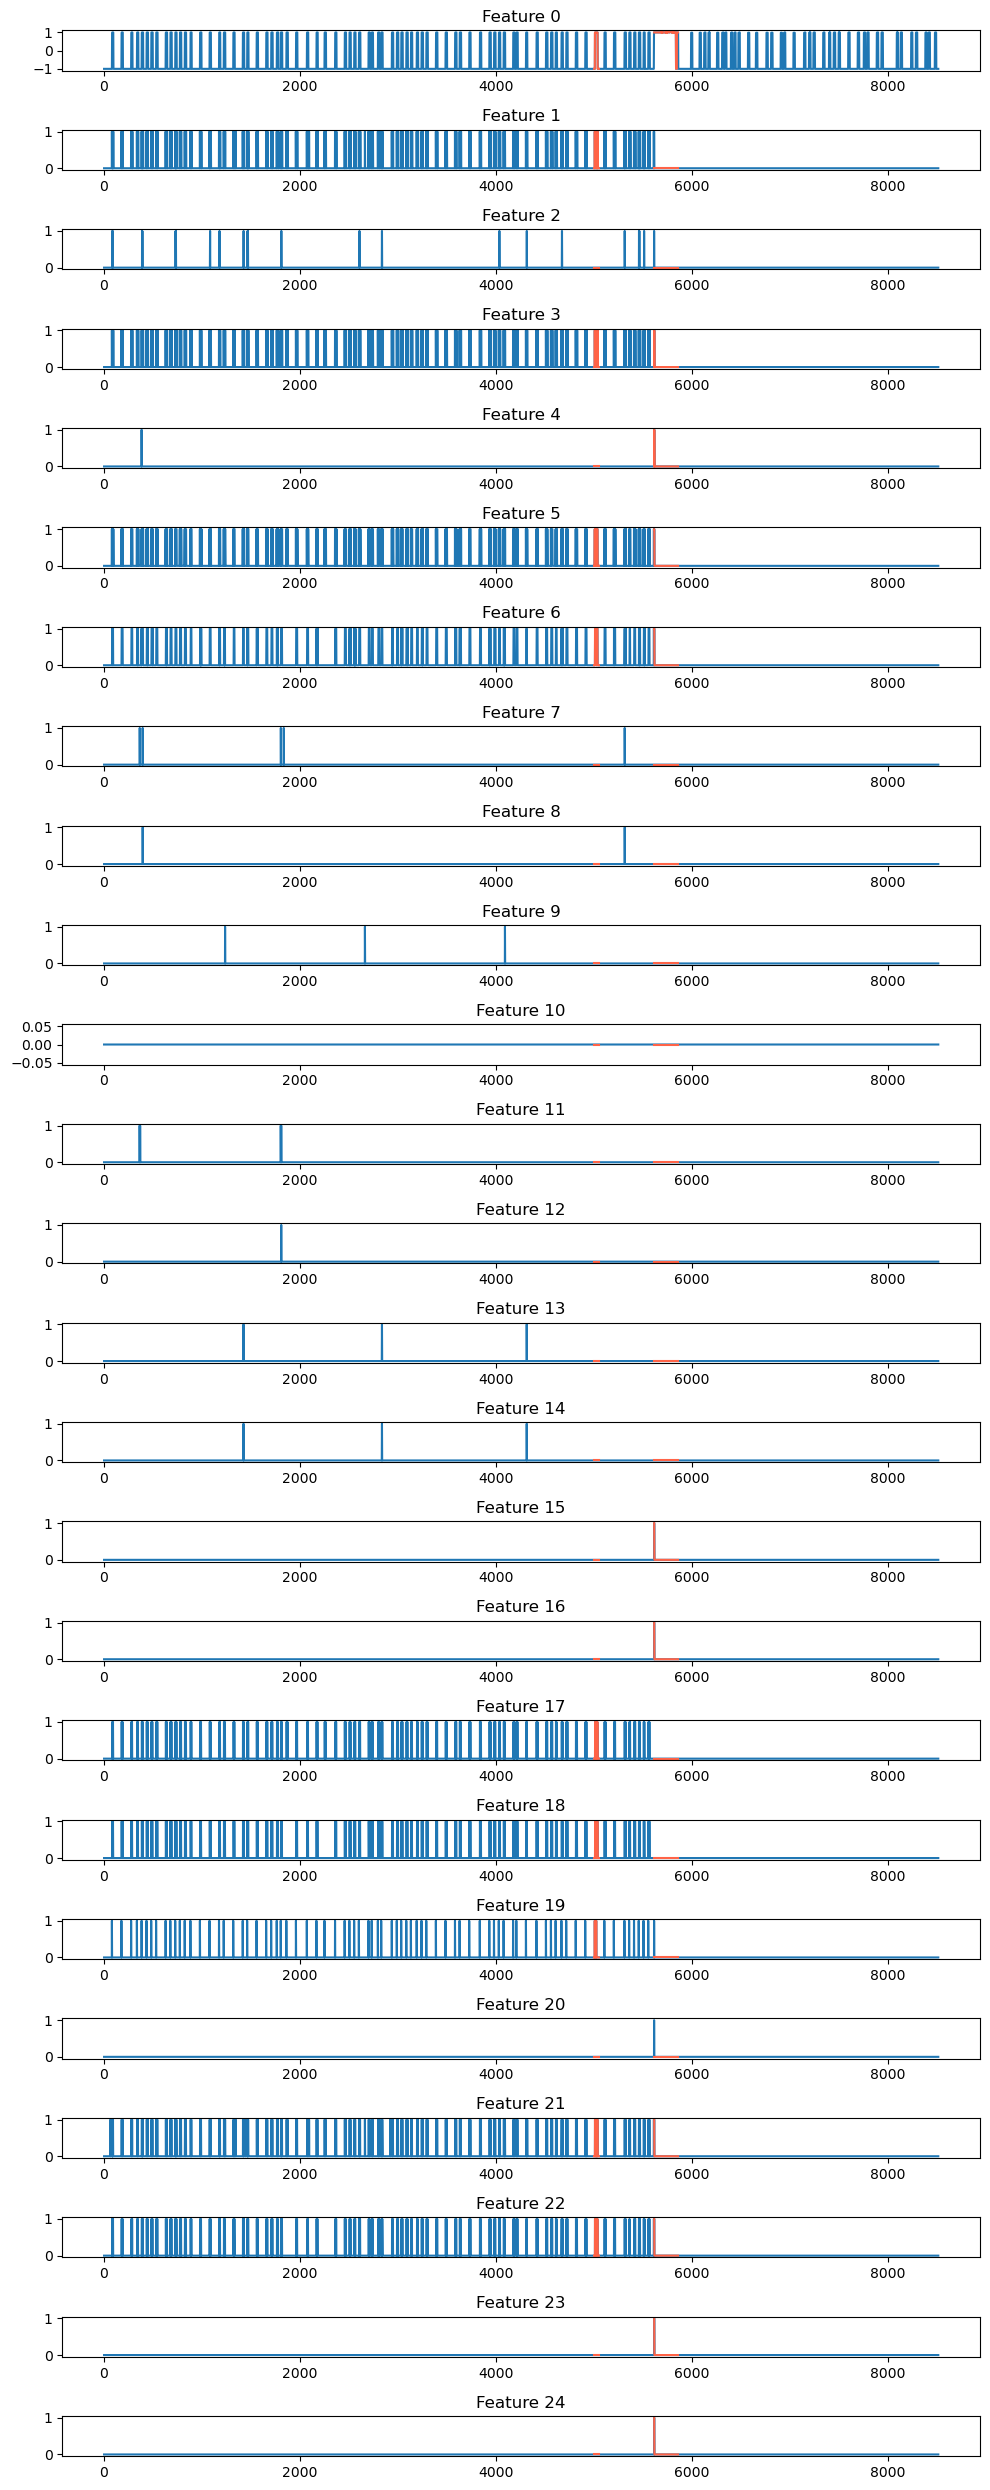

In [7]:
anomaly_index = label_df[label_df['chan_id']=='E-11']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-11.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-11']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_11'

In [11]:
run_all_and_save(ID,start=1,stop=10)

Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [12:34<00:00, 30.19s/it]

Max_error: 1.000 got 1/25 features detectable 
Max_error: 3.250 got 1/25 features detectable 
Max_error: 5.500 got 3/25 features detectable 
Max_error: 7.750 got 3/25 features detectable 
Max_error: 10.000 got 3/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,E_11,Topdown,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
264,E_11,Topdown,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
265,E_11,Topdown,5.50,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
266,E_11,Topdown,7.75,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [02:32<00:00,  6.09s/it]

Max_error: 3.250 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,E_11,Topdown,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
265,E_11,Topdown,5.50,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
266,E_11,Topdown,7.75,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
267,E_11,Topdown,10.00,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [01:31<00:00,  3.65s/it]

Max_error: 1.000 got 1/25 features detectable 
Max_error: 5.500 got 2/25 features detectable 
Max_error: 7.750 got 2/25 features detectable 
Max_error: 10.000 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,E_11,Bottomup,3.25,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
269,E_11,Slidingwindow,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
270,E_11,Slidingwindow,5.50,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
271,E_11,Slidingwindow,7.75,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2


Max error: 10.0000 loop: 100%|█████████████████████████████████████████████████████████| 25/25 [04:35<00:00, 11.02s/it]

Max_error: 1.000 got 1/25 features detectable 
Max_error: 3.250 got 1/25 features detectable 


,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
0,D_1,Topdown,1.00,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
1,D_1,Topdown,3.25,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
2,D_1,Topdown,5.50,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,17
3,D_1,Topdown,7.75,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
4,D_1,Topdown,10.00,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,E_11,Slidingwindow,5.50,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
271,E_11,Slidingwindow,7.75,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
272,E_11,Slidingwindow,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
273,E_11,SWAB,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
old_df = pd.read_csv('exp/Max_error_per_ID')
old_df[old_df['ID']=='E_11']

,ID,Algorithms,Max_error,P_type_1,P_type_2,P_type_3,P_type_4,P_type_5,P_type_6,P_type_7,...,P_type_17,P_type_18,P_type_19,P_type_20,P_type_21,P_type_22,P_type_23,P_type_24,P_type_25,Total
263,E_11,Topdown,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
264,E_11,Topdown,3.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
265,E_11,Topdown,5.50,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
266,E_11,Topdown,7.75,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
267,E_11,Topdown,10.00,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
268,E_11,Bottomup,3.25,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
269,E_11,Slidingwindow,1.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
270,E_11,Slidingwindow,5.50,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
271,E_11,Slidingwindow,7.75,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
272,E_11,Slidingwindow,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## E_13

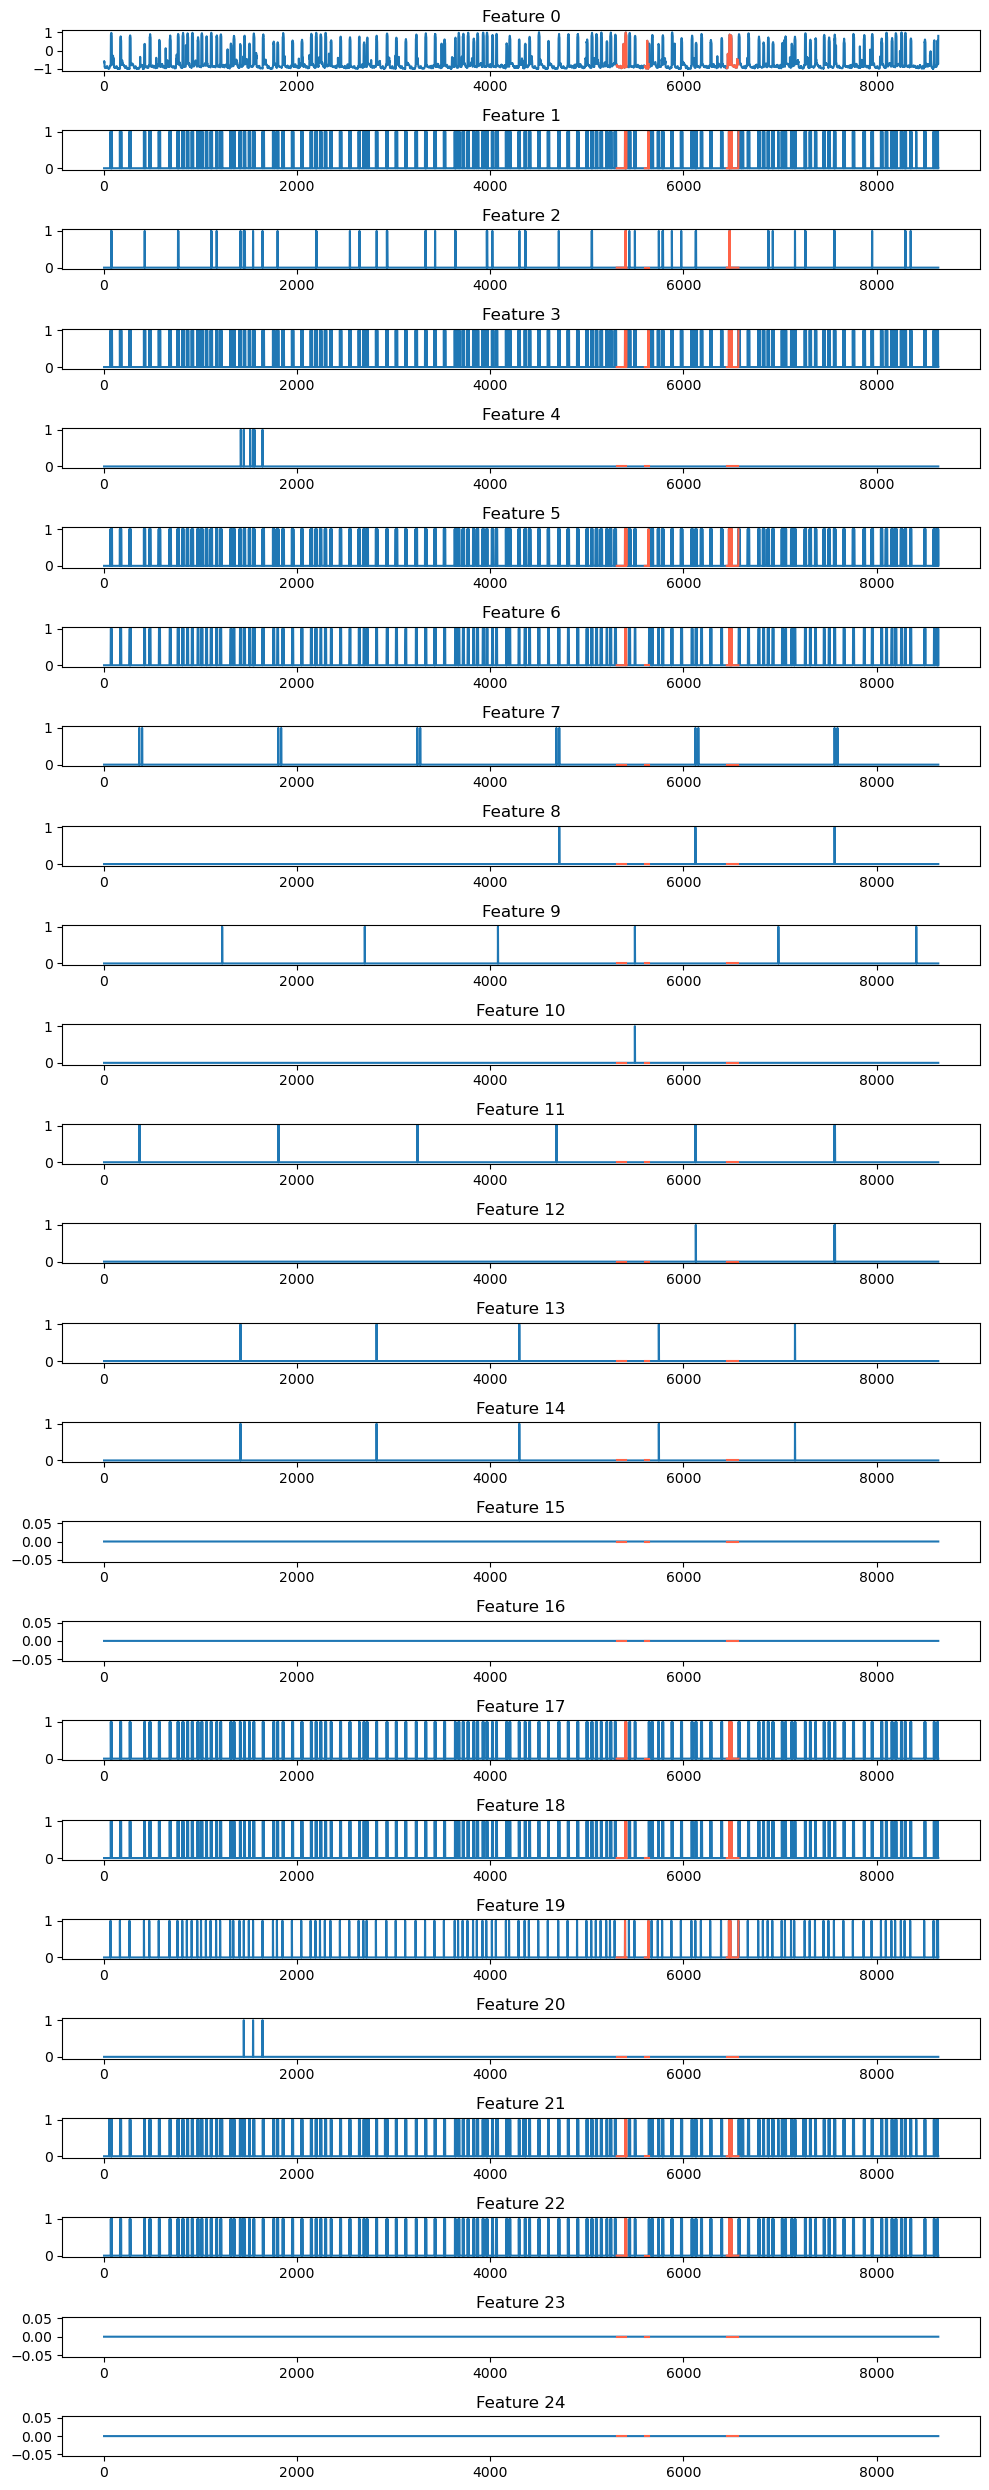

In [12]:
anomaly_index = label_df[label_df['chan_id']=='E-13']
attack_indx = anomaly_index.anomaly_sequences.values[0][0]
attack_indx = np.arange(attack_indx[0],attack_indx[1]+1,1)

data = np.load('data/test/E-13.npy')
df = pd.DataFrame(data)
anomaly_index = label_df[label_df['chan_id']=='E-13']
anomaly_index


fig,axs = plt.subplots(nrows=25, ncols=1, figsize=(10, 25))
axs_flat = axs.flatten()
anomaly_range = anomaly_index.anomaly_sequences.values[0]
for i in range(25):
    axs_flat[i].plot(df.iloc[:,i])
    for range_ in anomaly_range:
        axs_flat[i].plot(df.iloc[range_[0]:range_[1]+1,i],c='tomato')
        axs_flat[i].set_title(f"Feature {i}")
plt.tight_layout() 

ID = 'E_13'

# Here

# Chú ý xem đánh giá theo 2 loại:
## 1 là xem được nhiều id thì thể hiện điều gì
## 2 là mỗi id được nhiều product type thì có ý nghĩa gì?